In [64]:
import keras
import numpy as np
import keras
import tensorflow as tf
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization,Activation, Flatten
from keras.optimizers import SGD, rmsprop, Adam
from keras.regularizers import l1, l2
from keras.callbacks.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

In [2]:
# libraries for visualization
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from keras.utils import plot_model
from scipy.misc import toimage

# The Target

According to [this benchmark website](https://benchmarks.ai/cifar-10) the worst accepted performance of a deep neural network on this dataset is 75.86% using Shallow Convolutional Networks. The state of the art is Giant Neural Networks using Pipeline Parallelism (with 99% accuracy).

We will set a goal of **76% accuracy** on the test set, just marginally better than the worst model out there. We will also be mindful of execution time, given that we do not have access to GPUs. Therefore we set a maximum running time of **15 minutes** for each experiment. 

# The base-line model

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train.shape

(50000, 32, 32, 3)

In [4]:
y_train.shape

(50000, 1)

In [5]:
x_test.shape

(10000, 32, 32, 3)

We have 50,000 train samples and 10,000 test samples. The shape of the x vector is 32x32x3 (32x32 for 3 color bands). In order to fit in what keras expects, we will reshape it to a 3072 flat array. 

In [6]:
def show_imgs(X):
    """
    source: https://appliedmachinelearning.blog/2018/03/24/achieving-90-accuracy-in-object-recognition-task-on-cifar-10-dataset-with-keras-convolutional-neural-networks/
    """
    plt.figure(1, figsize=(20.0, 15.0))
    k = 0
    for i in range(0,4):
        for j in range(0,4):
            plt.subplot2grid((4,4),(i,j))
            plt.imshow(toimage(X[k]))
            k = k+1
    # show the plot
    plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  # Remove the CWD from sys.path while we load stuff.


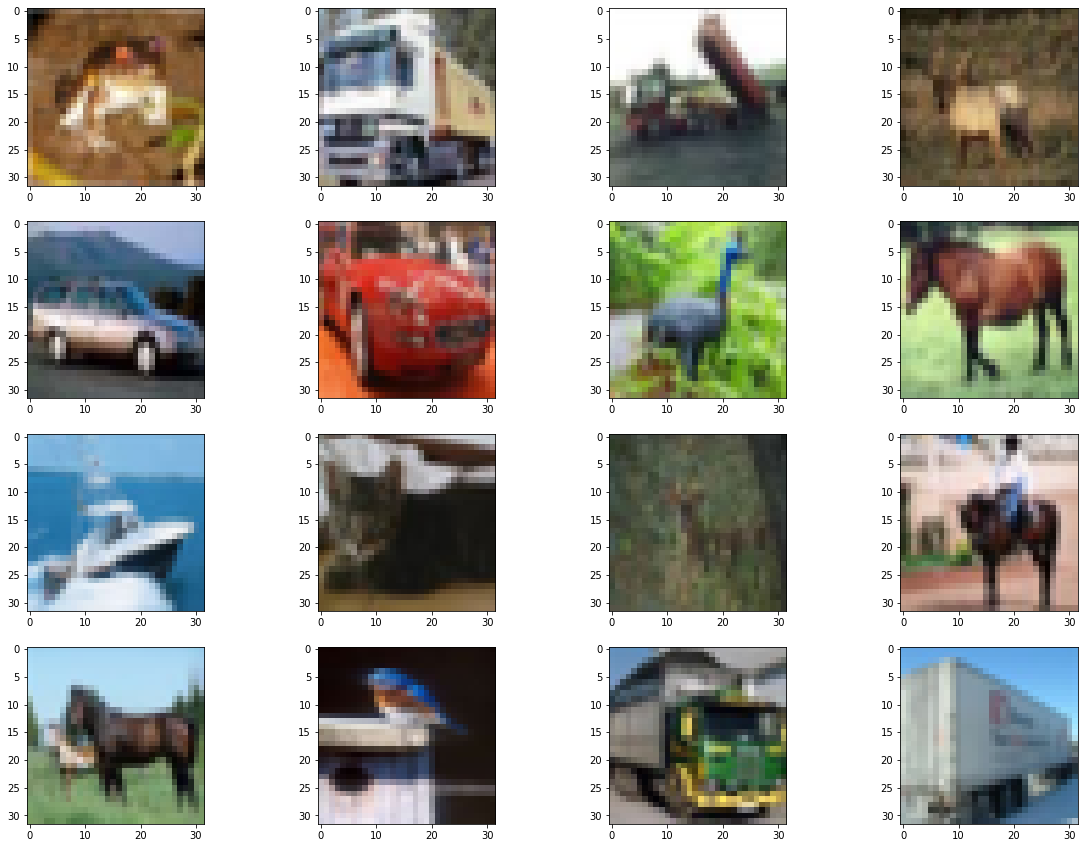

In [7]:
show_imgs(x_train[:16])

In [7]:
x_train = x_train.reshape(50000, 3072)
x_test = x_test.reshape(10000, 3072)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [8]:
x_train.min()

0.0

In [9]:
x_train.max()

255.0

We will divide by 255 which is the maximum value, in order to bring the data to the 0-1 range. 

In [10]:
x_train /= 255
x_test /= 255

We will split the y vector to a matrix of binary values with one column per available class

In [11]:
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

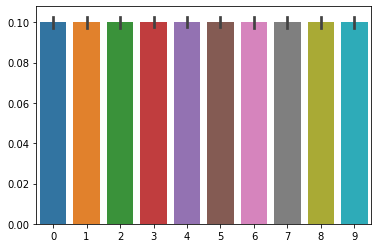

In [13]:
sns.barplot(data=y_train)

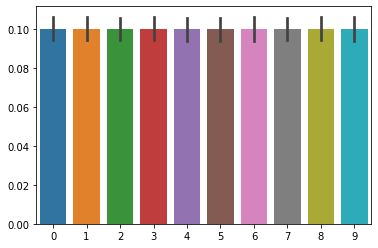

In [14]:
sns.barplot(data=y_test)

In [15]:
%%time
batch_size = 128
epochs = 40

model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(3072,)))
model.add(Dense(100, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               307300    
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
Total params: 318,410
Trainable params: 318,410
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/40
50000/50000 [==============================] - 2s 45us/step - loss: 2.0162 - accuracy: 0.2733 - val_loss: 1.8766 - val_accuracy: 0.3343
Epoch 2/40
50000/50000 [==============================] - 3s 51us/step - loss: 1.8363 - accuracy: 0.3484 - val_loss: 1.8131 - val_accuracy: 0.3575
Epoch 3/40
50000/50000 [==========

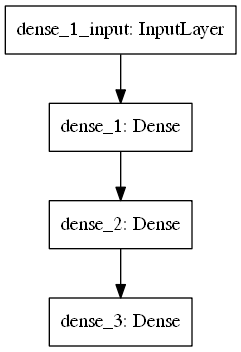

In [16]:
plot_model(model, to_file='model.png')

In [17]:
loss = pd.DataFrame.from_dict(history.history)
loss['epoch'] = loss.index+1

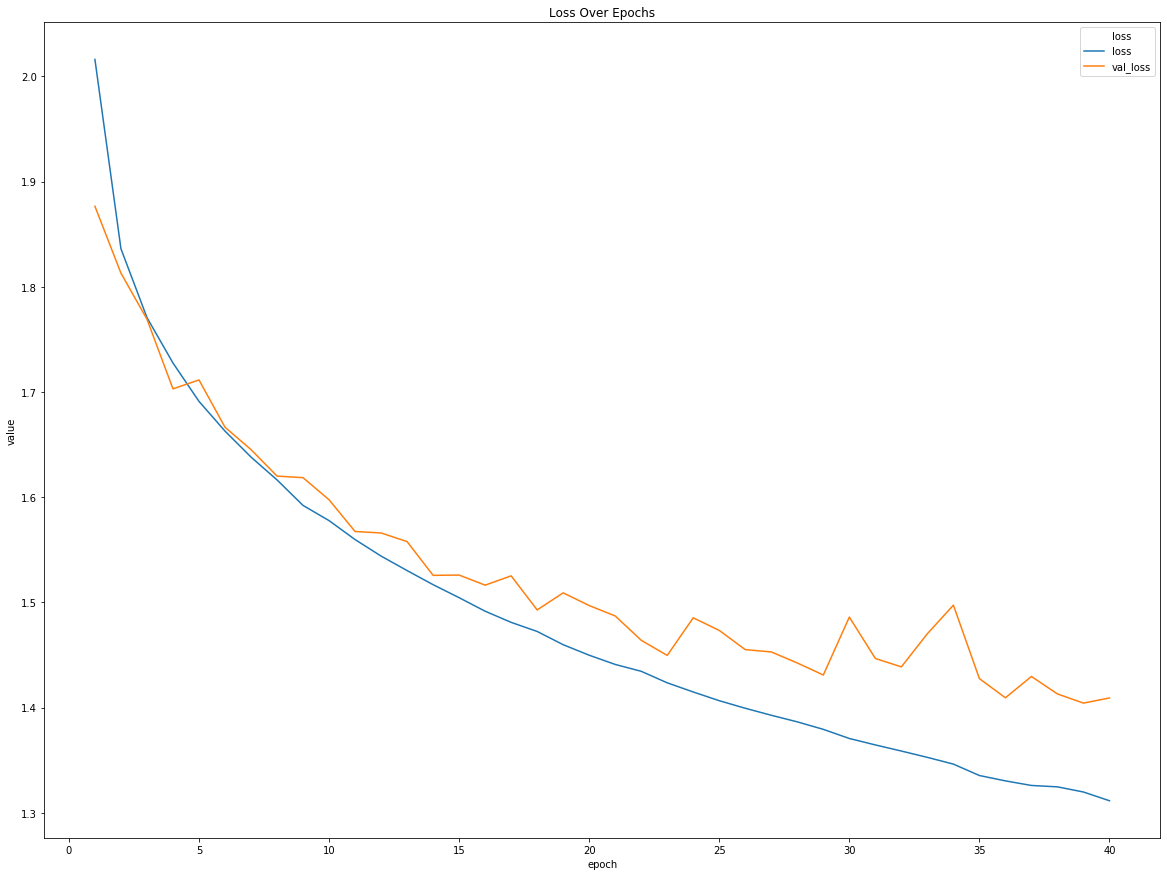

In [18]:
loss1 = loss[['epoch','loss', 'val_loss']].melt(id_vars=['epoch'], var_name='loss')
plt.figure(figsize=(20.0, 15.0))
plt.title('Loss Over Epochs')
plot = sns.lineplot(data=loss1, x='epoch', y='value', hue='loss')
fig = plot.get_figure()
fig.savefig("model_loss.png")

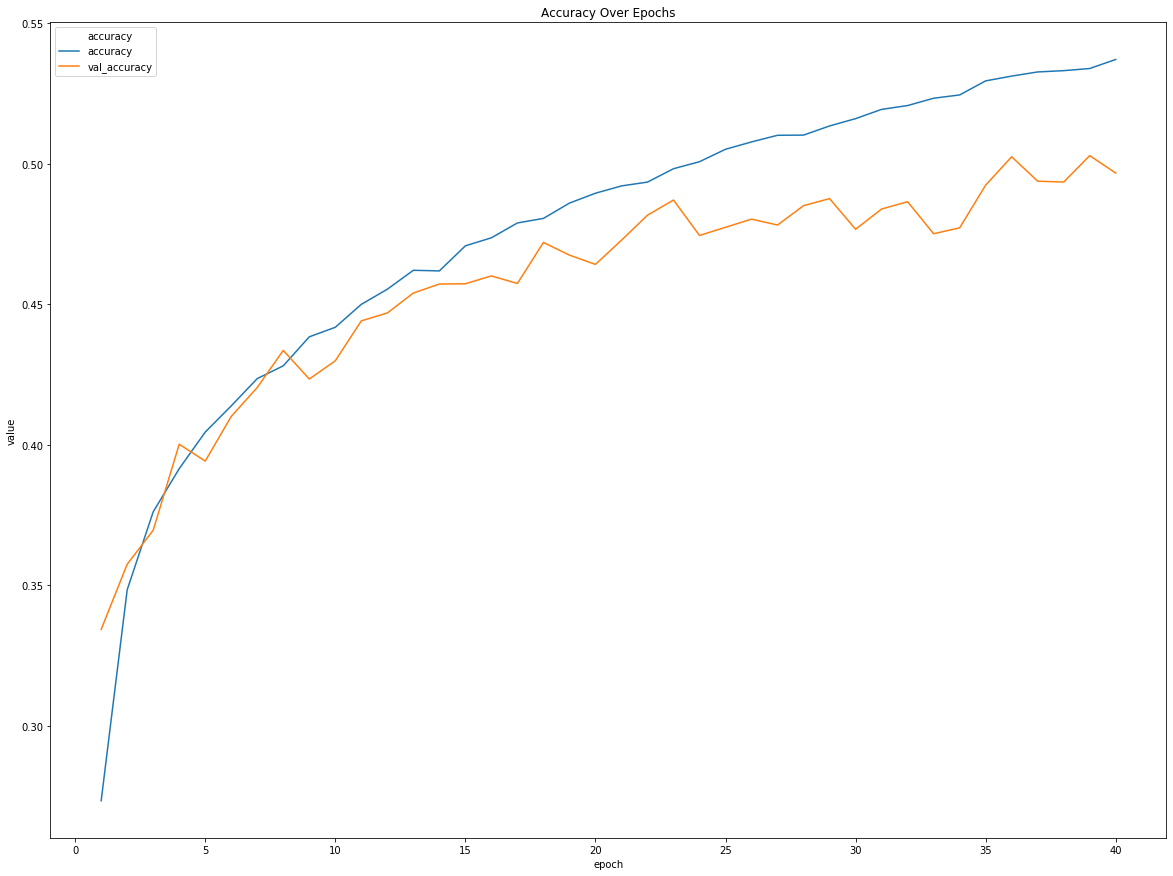

In [19]:
acc = loss[['epoch','accuracy', 'val_accuracy']].melt(id_vars=['epoch'], var_name='accuracy')
plt.figure(figsize=(20.0, 15.0))
plt.title('Accuracy Over Epochs')
plot = sns.lineplot(data=acc, x='epoch', y='value', hue='accuracy')
fig = plot.get_figure()
fig.savefig("model_accuracy.png")

# 1st attempt

We have very low accuracy. Therefore we will initially attempt to increase the capacity of the network, by increasing the depth, by one layer

In [20]:
%%time
batch_size = 128
epochs = 40

model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(3072,)))
model.add(Dense(100, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 100)               307300    
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_6 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_7 (Dense)              (None, 10)                1010      
Total params: 328,510
Trainable params: 328,510
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/40
50000/50000 [==============================] - 2s 46us/step - loss: 2.0561 - accuracy: 0.2633 - val_loss: 1.9011 - val_accuracy: 0.3292
Epoch 2/40
50000/50000 [=========================

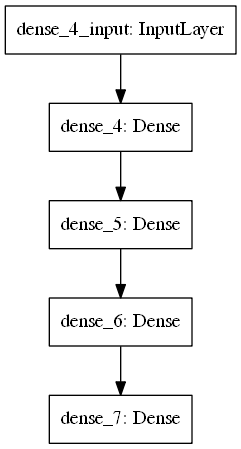

In [21]:
plot_model(model, to_file='model01.png')

In [22]:
loss = pd.DataFrame.from_dict(history.history)
loss['epoch'] = loss.index+1

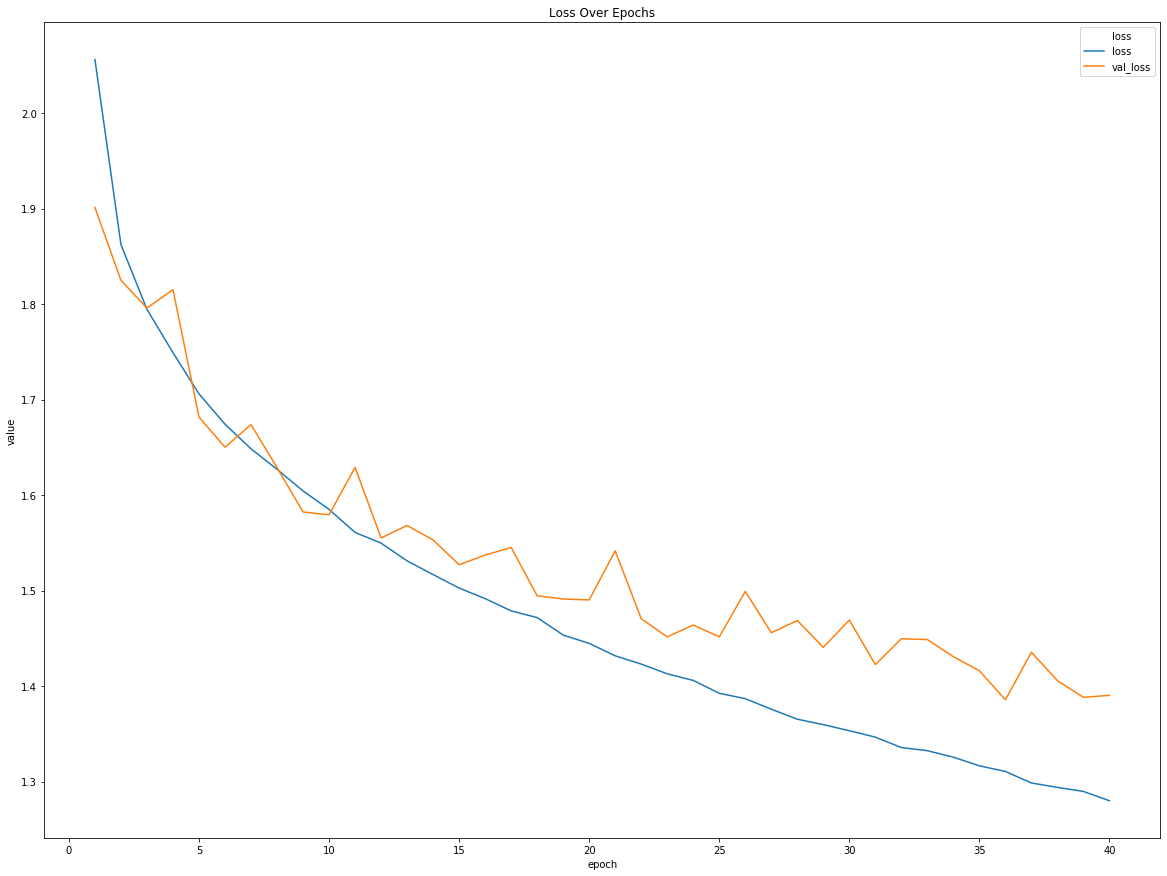

In [23]:
loss1 = loss[['epoch','loss', 'val_loss']].melt(id_vars=['epoch'], var_name='loss')
plt.figure(figsize=(20.0, 15.0))
plt.title('Loss Over Epochs')
plot = sns.lineplot(data=loss1, x='epoch', y='value', hue='loss')
fig = plot.get_figure()
fig.savefig("model01_loss.png")

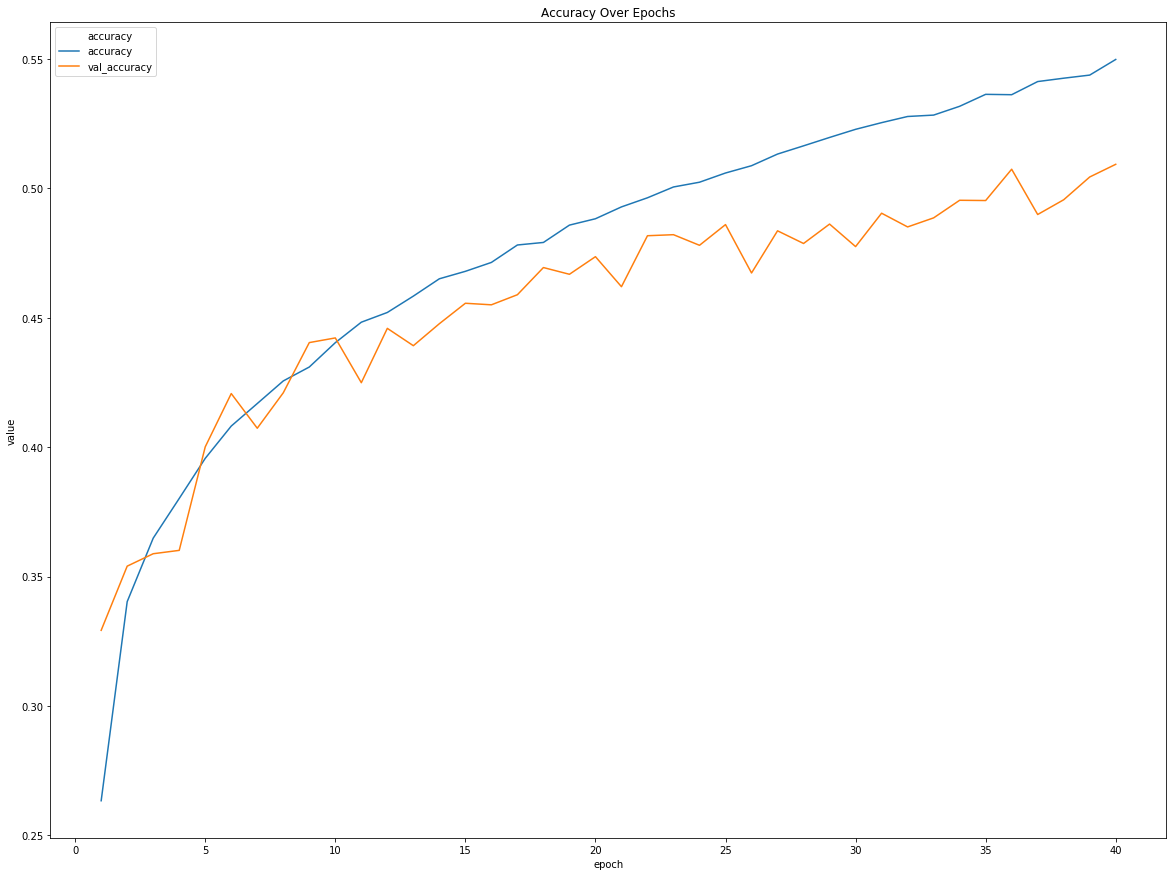

In [24]:
acc = loss[['epoch','accuracy', 'val_accuracy']].melt(id_vars=['epoch'], var_name='accuracy')
fig = plt.figure(figsize=(20.0, 15.0))
plt.title('Accuracy Over Epochs')
sns.lineplot(data=acc, x='epoch', y='value', hue='accuracy')
fig.savefig("model01_accuracy.png")

# 2nd Attempt

Still underfit. Before adding another layer, we will experiment a bit with the width of each layer

In [25]:
%%time
batch_size = 128
epochs = 40

model = Sequential()
model.add(Dense(200, activation='relu', input_shape=(3072,)))
model.add(Dense(200, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 200)               614600    
_________________________________________________________________
dense_9 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_10 (Dense)             (None, 200)               40200     
_________________________________________________________________
dense_11 (Dense)             (None, 10)                2010      
Total params: 697,010
Trainable params: 697,010
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/40
50000/50000 [==============================] - 4s 72us/step - loss: 2.0437 - accuracy: 0.2728 - val_loss: 1.9194 - val_accuracy: 0.3038
Epoch 2/40
50000/50000 [=========================

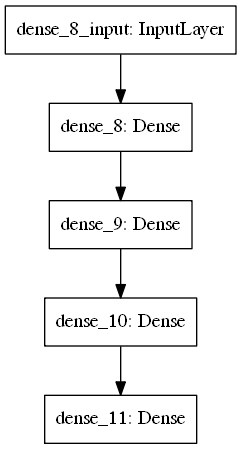

In [26]:
plot_model(model, to_file='model02.png')

In [27]:
loss = pd.DataFrame.from_dict(history.history)
loss['epoch'] = loss.index+1

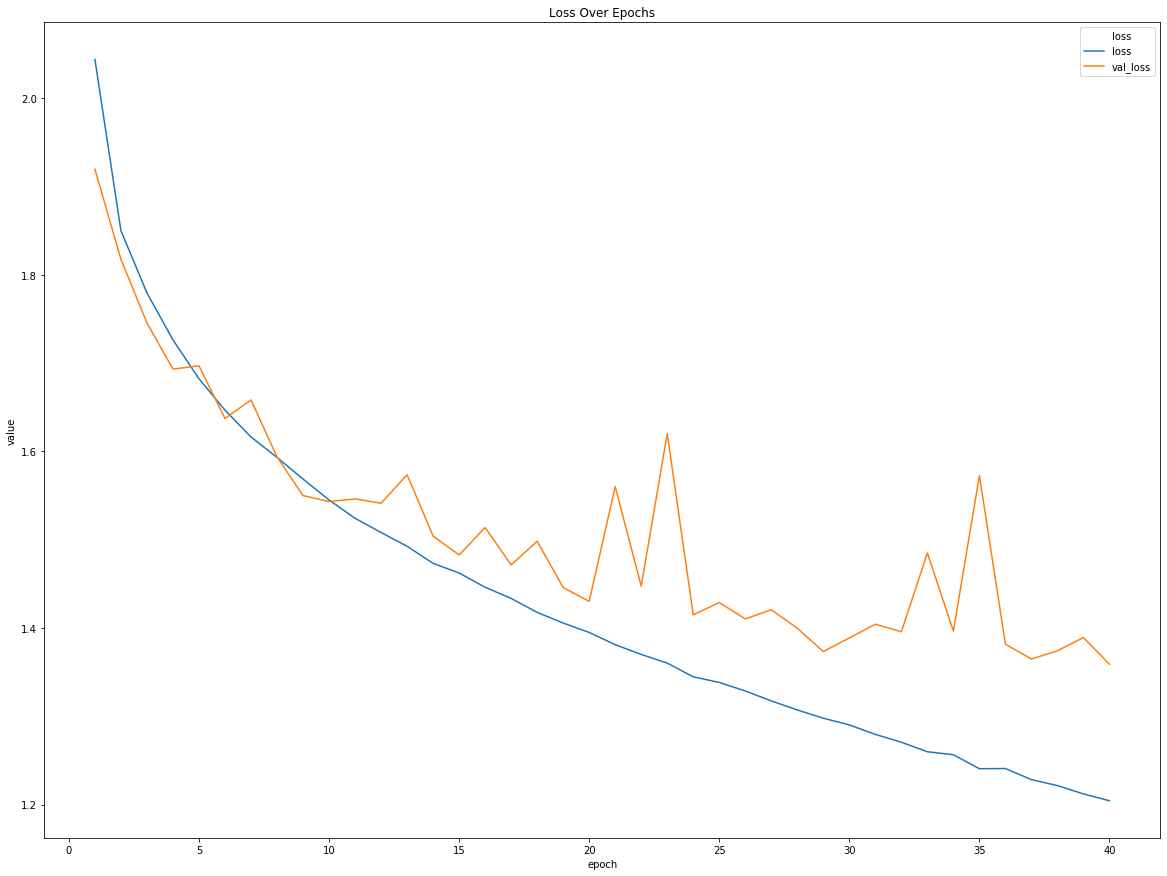

In [28]:
loss1 = loss[['epoch','loss', 'val_loss']].melt(id_vars=['epoch'], var_name='loss')
plt.figure(figsize=(20.0, 15.0))
plt.title('Loss Over Epochs')
plot = sns.lineplot(data=loss1, x='epoch', y='value', hue='loss')
fig = plot.get_figure()
fig.savefig("model02_loss.png")

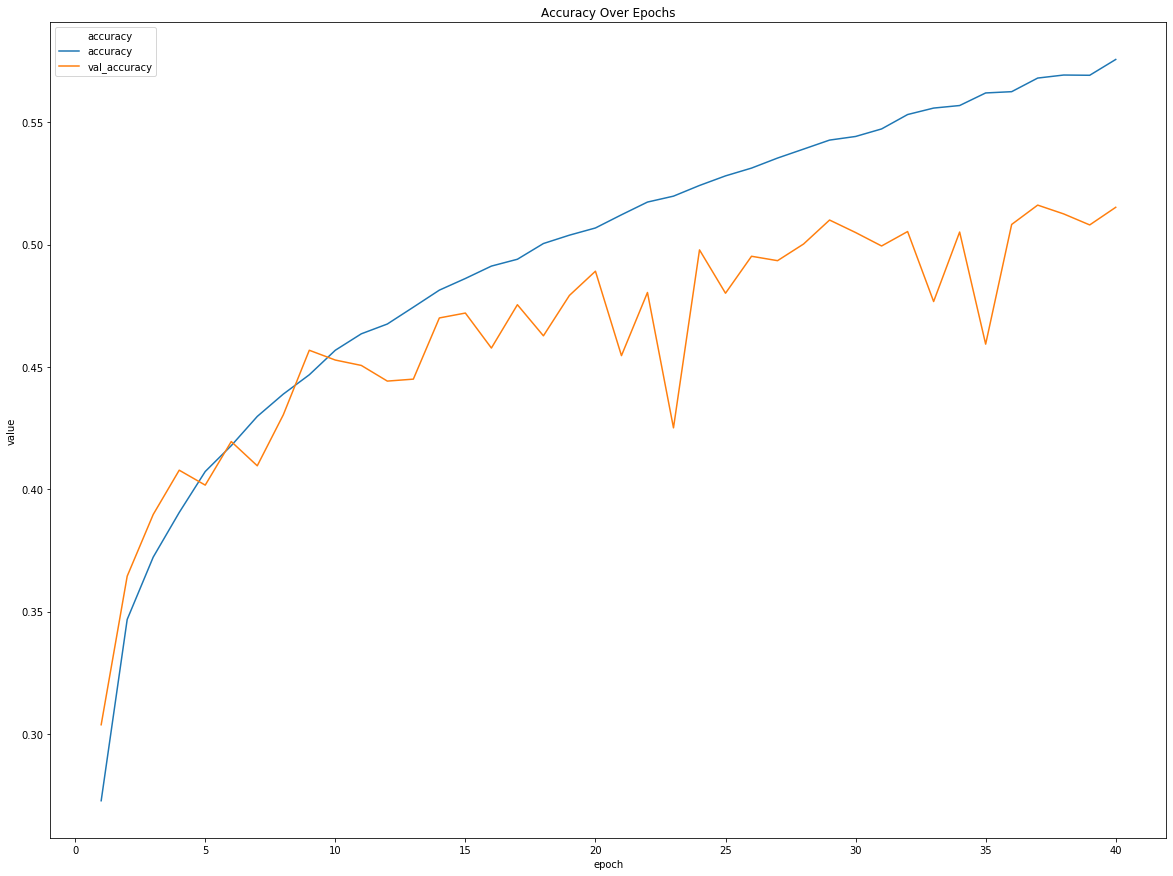

In [29]:
acc = loss[['epoch','accuracy', 'val_accuracy']].melt(id_vars=['epoch'], var_name='accuracy')
fig = plt.figure(figsize=(20.0, 15.0))
plt.title('Accuracy Over Epochs')
sns.lineplot(data=acc, x='epoch', y='value', hue='accuracy')
plt.show()
fig.savefig("model02_accuracy.png")

# 3rd Attempt

We saw some improvement but still there is a distance between train and test accuracy which seems to diverge. We will increase the width and depth, before attempting to solve that. 

In [48]:
%%time
batch_size = 128
epochs = 40

model = Sequential()
model.add(Dense(400, activation='relu', input_shape=(3072,)))
model.add(Dense(400, activation='relu'))
model.add(Dense(400, activation='relu'))
model.add(Dense(400, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 400)               1229200   
_________________________________________________________________
dense_33 (Dense)             (None, 400)               160400    
_________________________________________________________________
dense_34 (Dense)             (None, 400)               160400    
_________________________________________________________________
dense_35 (Dense)             (None, 400)               160400    
_________________________________________________________________
dense_36 (Dense)             (None, 10)                4010      
Total params: 1,714,410
Trainable params: 1,714,410
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/40
50000/50000 [==============================] - 7s

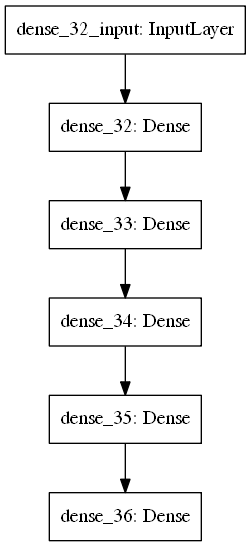

In [49]:
plot_model(model, to_file='model03.png')

In [50]:
loss = pd.DataFrame.from_dict(history.history)
loss['epoch'] = loss.index+1

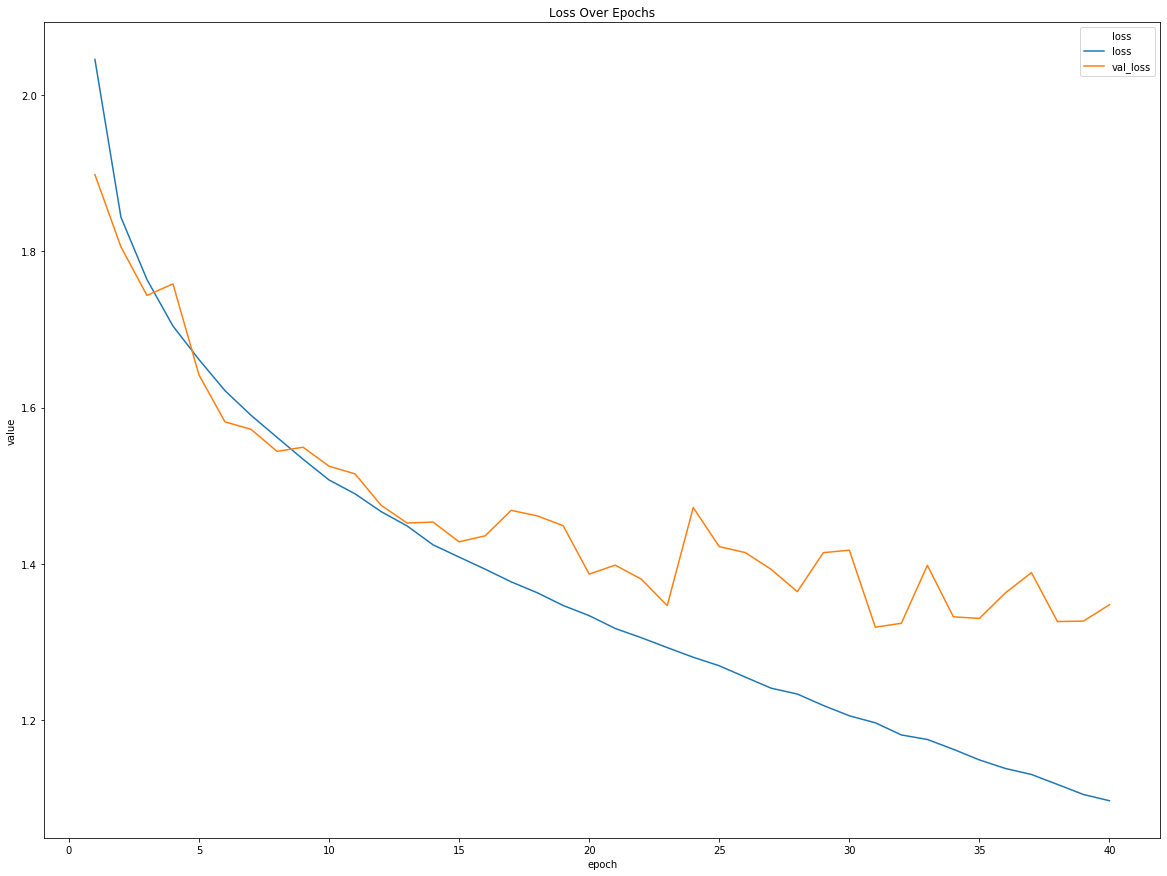

In [51]:
loss1 = loss[['epoch','loss', 'val_loss']].melt(id_vars=['epoch'], var_name='loss')
plt.figure(figsize=(20.0, 15.0))
plt.title('Loss Over Epochs')
plot = sns.lineplot(data=loss1, x='epoch', y='value', hue='loss')
fig = plot.get_figure()
fig.savefig("model03_loss.png")

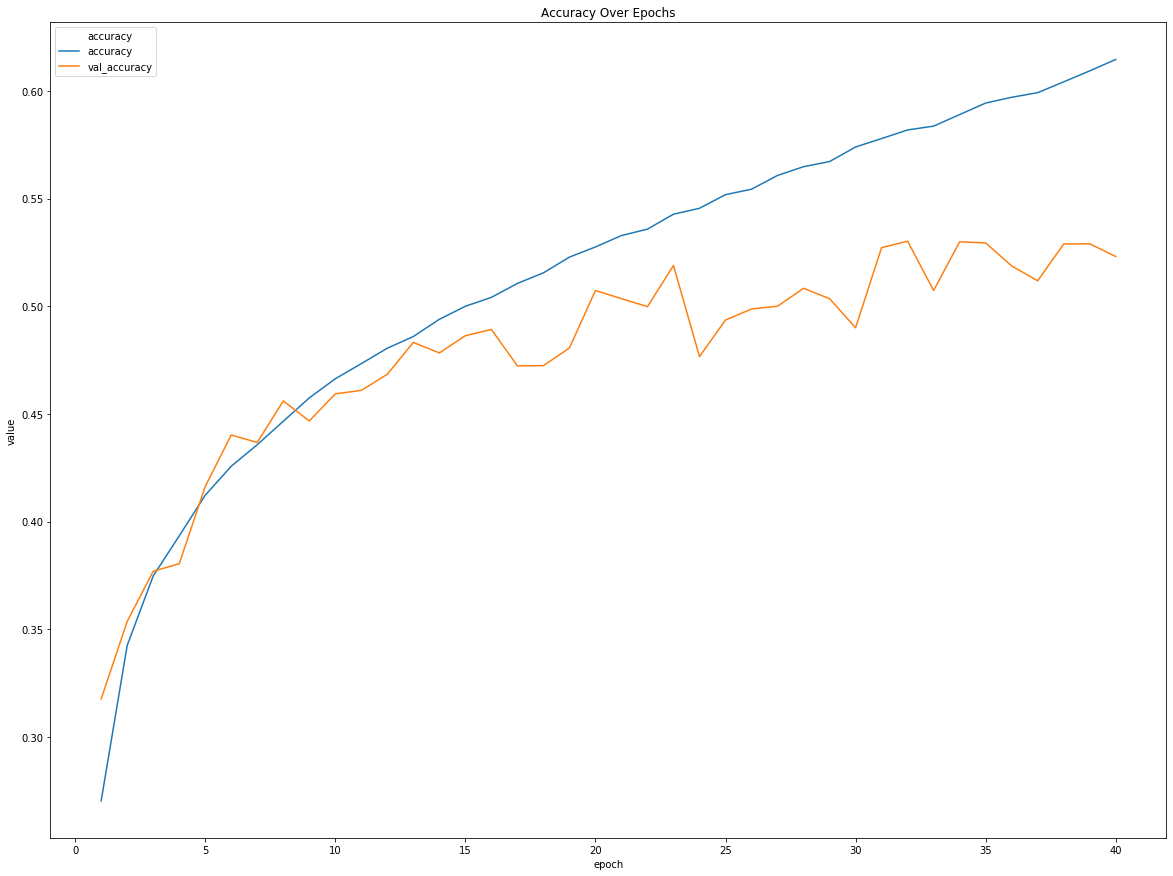

In [52]:
acc = loss[['epoch','accuracy', 'val_accuracy']].melt(id_vars=['epoch'], var_name='accuracy')
fig = plt.figure(figsize=(20.0, 15.0))
plt.title('Accuracy Over Epochs')
sns.lineplot(data=acc, x='epoch', y='value', hue='accuracy')
plt.show()
fig.savefig("model03_accuracy.png")

It is obvious that, while accuracy on the train set increases, the accuracy on the test set stays stable. We need to address this. 

We also notice that while initially the test loss is dropping, in convergence to the train loss, it starts diverging after epoch 15. 

# 4th Attempt

This time, we will try to solve the problem by introducing learning rate decay in the optimiser.

In [53]:
print("Current optimizer params")
print(SGD().get_config())

Current optimizer params
{'learning_rate': 0.009999999776482582, 'momentum': 0.0, 'decay': 0.0, 'nesterov': False}


We induce a learning rate decay of 1e-9

In [54]:
%%time
batch_size = 128
epochs = 40

model = Sequential()
model.add(Dense(400, activation='relu', input_shape=(3072,)))
model.add(Dense(400, activation='relu'))
model.add(Dense(400, activation='relu'))
model.add(Dense(400, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(decay=1e-9),
              metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 400)               1229200   
_________________________________________________________________
dense_38 (Dense)             (None, 400)               160400    
_________________________________________________________________
dense_39 (Dense)             (None, 400)               160400    
_________________________________________________________________
dense_40 (Dense)             (None, 400)               160400    
_________________________________________________________________
dense_41 (Dense)             (None, 10)                4010      
Total params: 1,714,410
Trainable params: 1,714,410
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/40
50000/50000 [==============================] - 7s

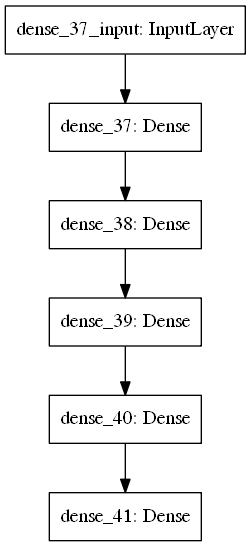

In [55]:
plot_model(model, to_file='model04.png')

In [56]:
loss = pd.DataFrame.from_dict(history.history)
loss['epoch'] = loss.index+1

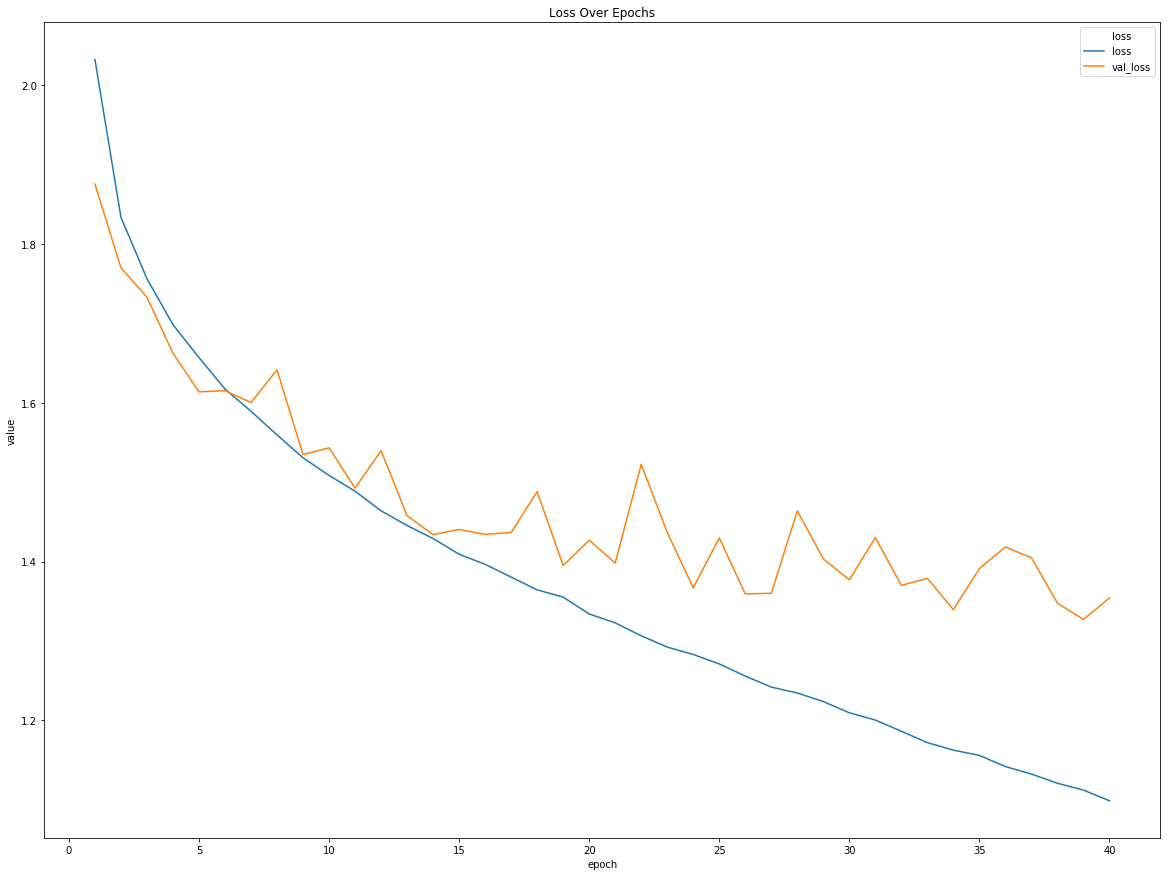

In [57]:
loss1 = loss[['epoch','loss', 'val_loss']].melt(id_vars=['epoch'], var_name='loss')
plt.figure(figsize=(20.0, 15.0))
plt.title('Loss Over Epochs')
plot = sns.lineplot(data=loss1, x='epoch', y='value', hue='loss')
fig = plot.get_figure()
fig.savefig("model04_loss.png")

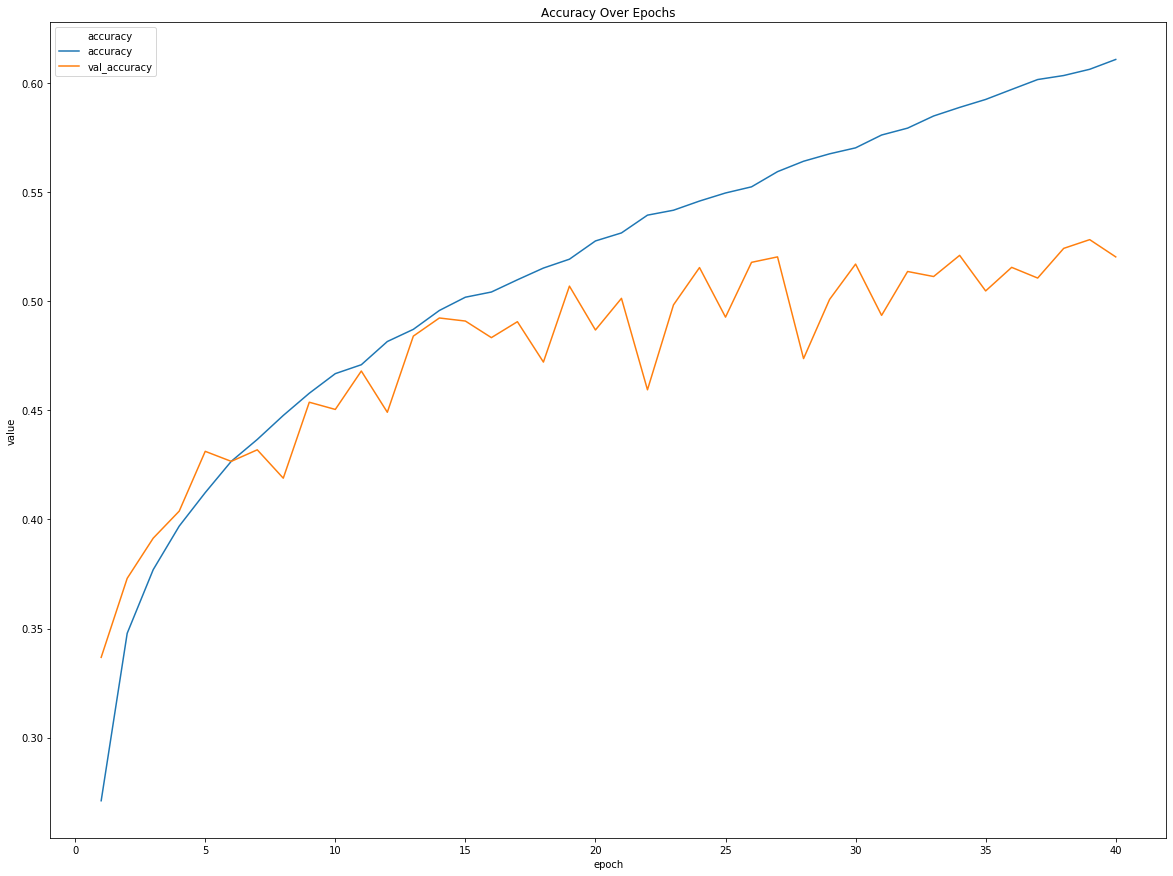

In [58]:
acc = loss[['epoch','accuracy', 'val_accuracy']].melt(id_vars=['epoch'], var_name='accuracy')
fig = plt.figure(figsize=(20.0, 15.0))
plt.title('Accuracy Over Epochs')
sns.lineplot(data=acc, x='epoch', y='value', hue='accuracy')
plt.show()
fig.savefig("model04_accuracy.png")

We see a marginally better performance. We will further tweak the optimizer by adding a Nestorov momentum

# 5th attempt

In [59]:
%%time
batch_size = 128
epochs = 40

model = Sequential()
model.add(Dense(400, activation='relu', input_shape=(3072,)))
model.add(Dense(400, activation='relu'))
model.add(Dense(400, activation='relu'))
model.add(Dense(400, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(momentum = 0.01, nesterov=True),
              metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 400)               1229200   
_________________________________________________________________
dense_43 (Dense)             (None, 400)               160400    
_________________________________________________________________
dense_44 (Dense)             (None, 400)               160400    
_________________________________________________________________
dense_45 (Dense)             (None, 400)               160400    
_________________________________________________________________
dense_46 (Dense)             (None, 10)                4010      
Total params: 1,714,410
Trainable params: 1,714,410
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/40
50000/50000 [==============================] - 9

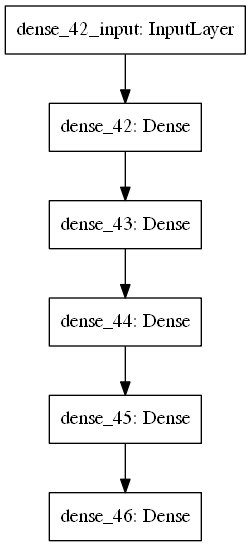

In [60]:
plot_model(model, to_file='model05.png')

In [61]:
loss = pd.DataFrame.from_dict(history.history)
loss['epoch'] = loss.index+1

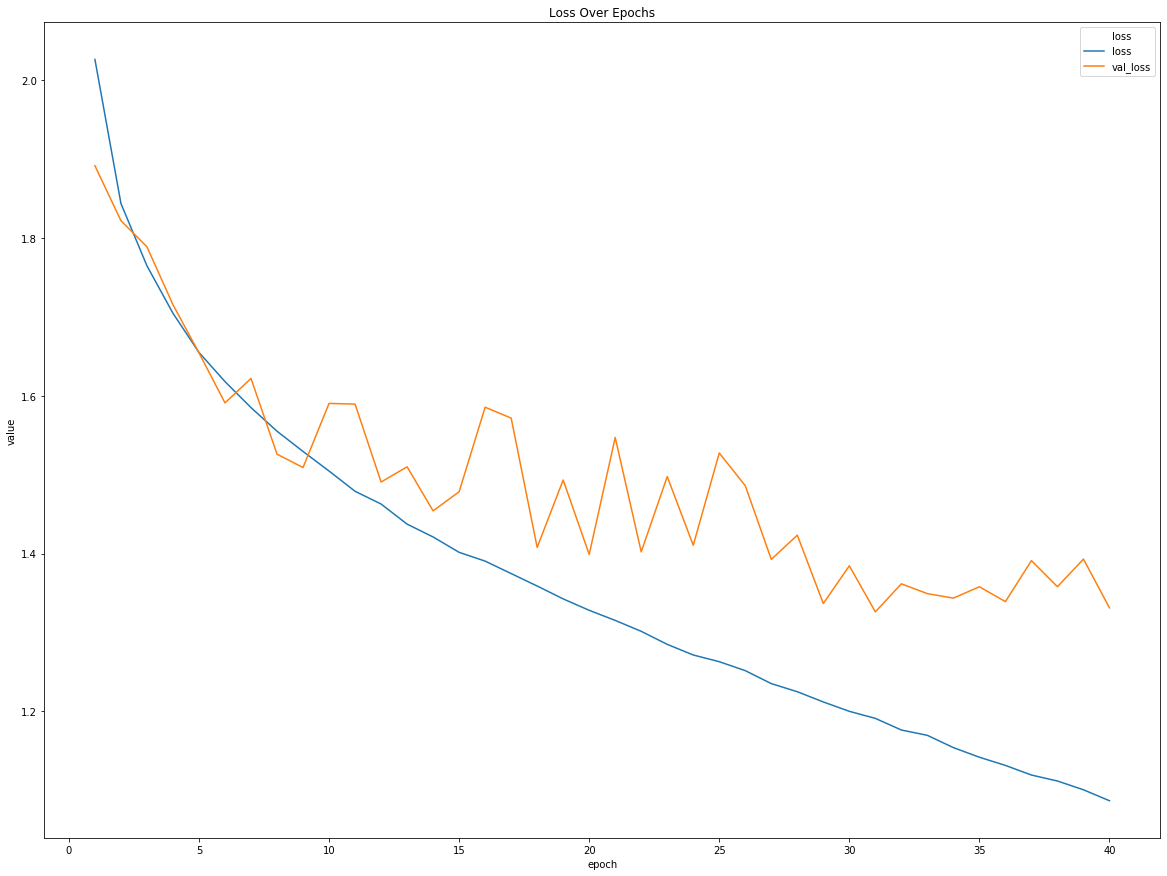

In [62]:
loss1 = loss[['epoch','loss', 'val_loss']].melt(id_vars=['epoch'], var_name='loss')
plt.figure(figsize=(20.0, 15.0))
plt.title('Loss Over Epochs')
plot = sns.lineplot(data=loss1, x='epoch', y='value', hue='loss')
fig = plot.get_figure()
fig.savefig("model05_loss.png")

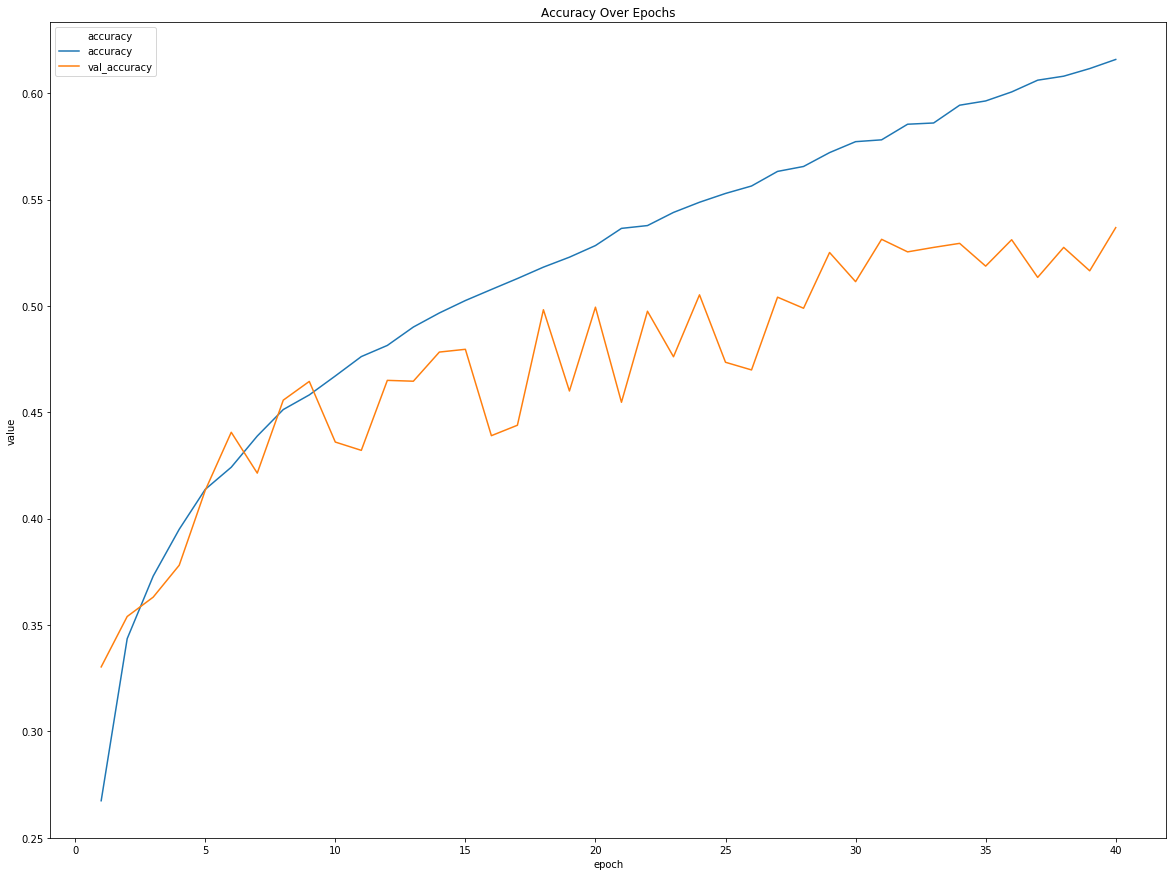

In [63]:
acc = loss[['epoch','accuracy', 'val_accuracy']].melt(id_vars=['epoch'], var_name='accuracy')
fig = plt.figure(figsize=(20.0, 15.0))
plt.title('Accuracy Over Epochs')
sns.lineplot(data=acc, x='epoch', y='value', hue='accuracy')
plt.show()
fig.savefig("model05_accuracy.png")

# 6th Attempt

The problem persists, so we try an adaptive momentum optimizer

In [64]:
%%time
batch_size = 128
epochs = 40

model = Sequential()
model.add(Dense(400, activation='relu', input_shape=(3072,)))
model.add(Dense(400, activation='relu'))
model.add(Dense(400, activation='relu'))
model.add(Dense(400, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer=rmsprop(),
              metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_47 (Dense)             (None, 400)               1229200   
_________________________________________________________________
dense_48 (Dense)             (None, 400)               160400    
_________________________________________________________________
dense_49 (Dense)             (None, 400)               160400    
_________________________________________________________________
dense_50 (Dense)             (None, 400)               160400    
_________________________________________________________________
dense_51 (Dense)             (None, 10)                4010      
Total params: 1,714,410
Trainable params: 1,714,410
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/40
50000/50000 [==============================] - 1

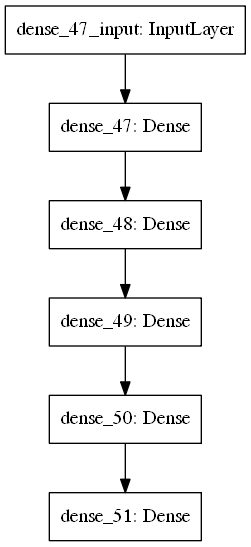

In [65]:
plot_model(model, to_file='model06.png')

In [66]:
loss = pd.DataFrame.from_dict(history.history)
loss['epoch'] = loss.index+1

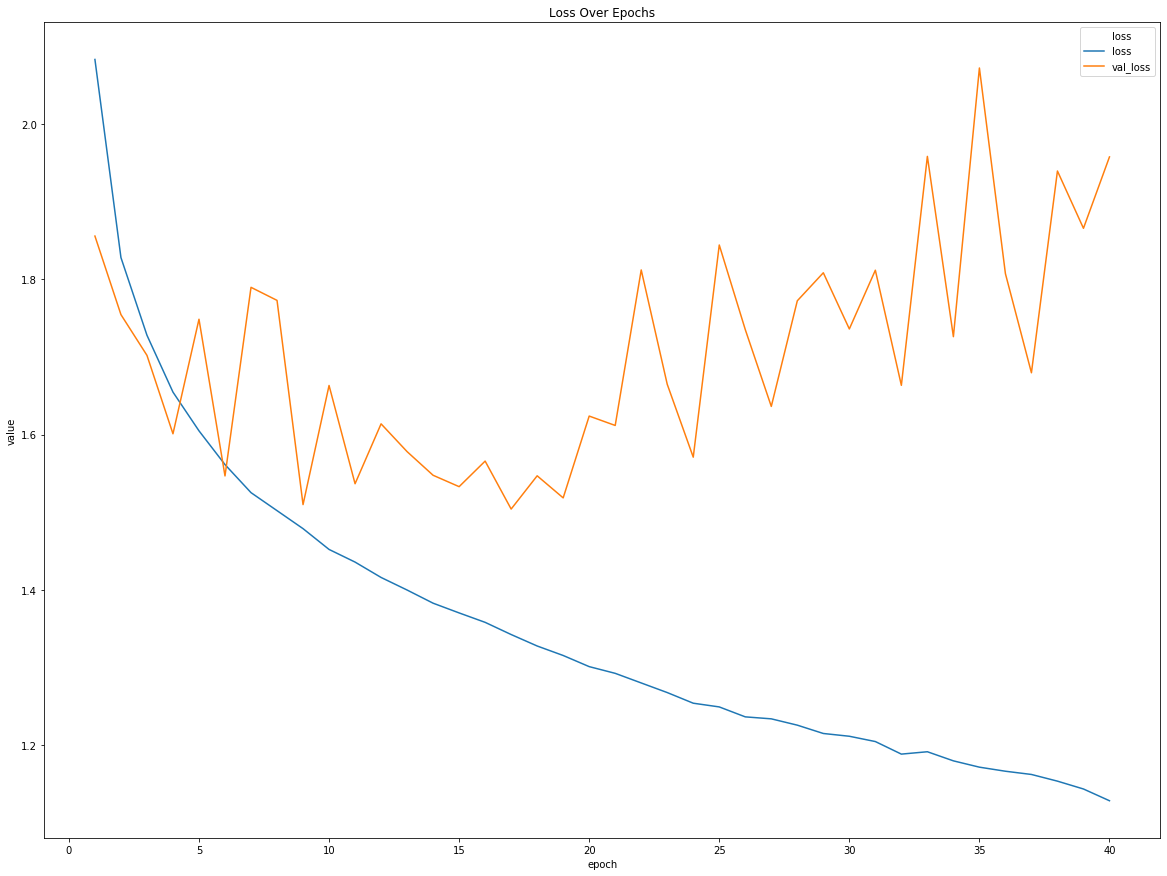

In [67]:
loss1 = loss[['epoch','loss', 'val_loss']].melt(id_vars=['epoch'], var_name='loss')
plt.figure(figsize=(20.0, 15.0))
plt.title('Loss Over Epochs')
plot = sns.lineplot(data=loss1, x='epoch', y='value', hue='loss')
fig = plot.get_figure()
fig.savefig("model06_loss.png")

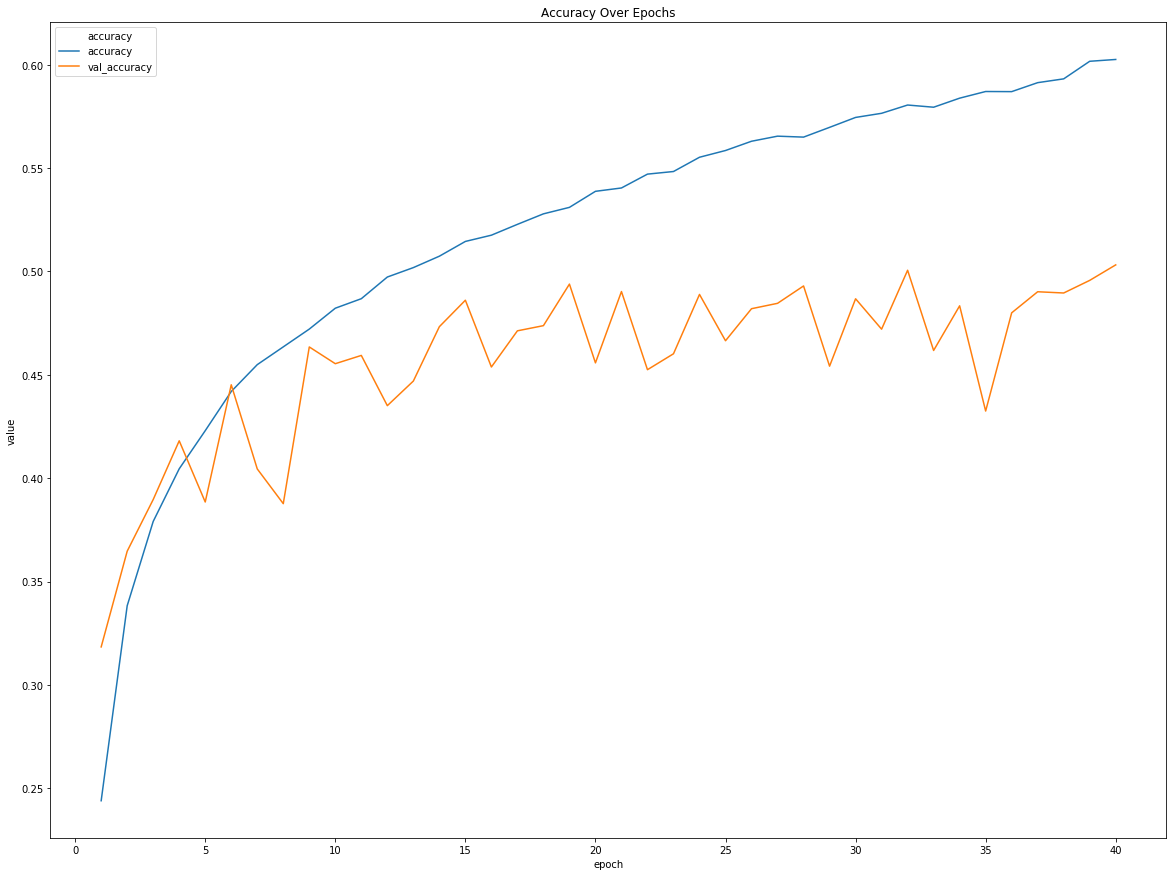

In [68]:
acc = loss[['epoch','accuracy', 'val_accuracy']].melt(id_vars=['epoch'], var_name='accuracy')
fig = plt.figure(figsize=(20.0, 15.0))
plt.title('Accuracy Over Epochs')
sns.lineplot(data=acc, x='epoch', y='value', hue='accuracy')
plt.show()
fig.savefig("model06_accuracy.png")

This was obviously a bad idea.

# 7th Attempt

This time around, we try out the Adam optimizer, to see if it can improve the learning rate convergence. 

In [69]:
%%time
batch_size = 128
epochs = 40

model = Sequential()
model.add(Dense(400, activation='relu', input_shape=(3072,)))
model.add(Dense(400, activation='relu'))
model.add(Dense(400, activation='relu'))
model.add(Dense(400, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_52 (Dense)             (None, 400)               1229200   
_________________________________________________________________
dense_53 (Dense)             (None, 400)               160400    
_________________________________________________________________
dense_54 (Dense)             (None, 400)               160400    
_________________________________________________________________
dense_55 (Dense)             (None, 400)               160400    
_________________________________________________________________
dense_56 (Dense)             (None, 10)                4010      
Total params: 1,714,410
Trainable params: 1,714,410
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/40
50000/50000 [==============================] - 1

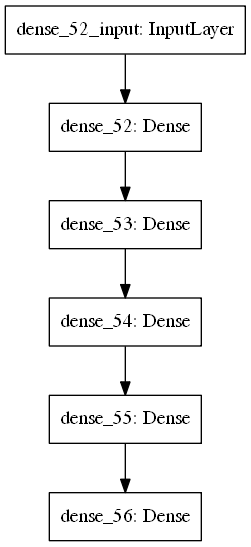

In [70]:
plot_model(model, to_file='model07.png')

In [71]:
loss = pd.DataFrame.from_dict(history.history)
loss['epoch'] = loss.index+1

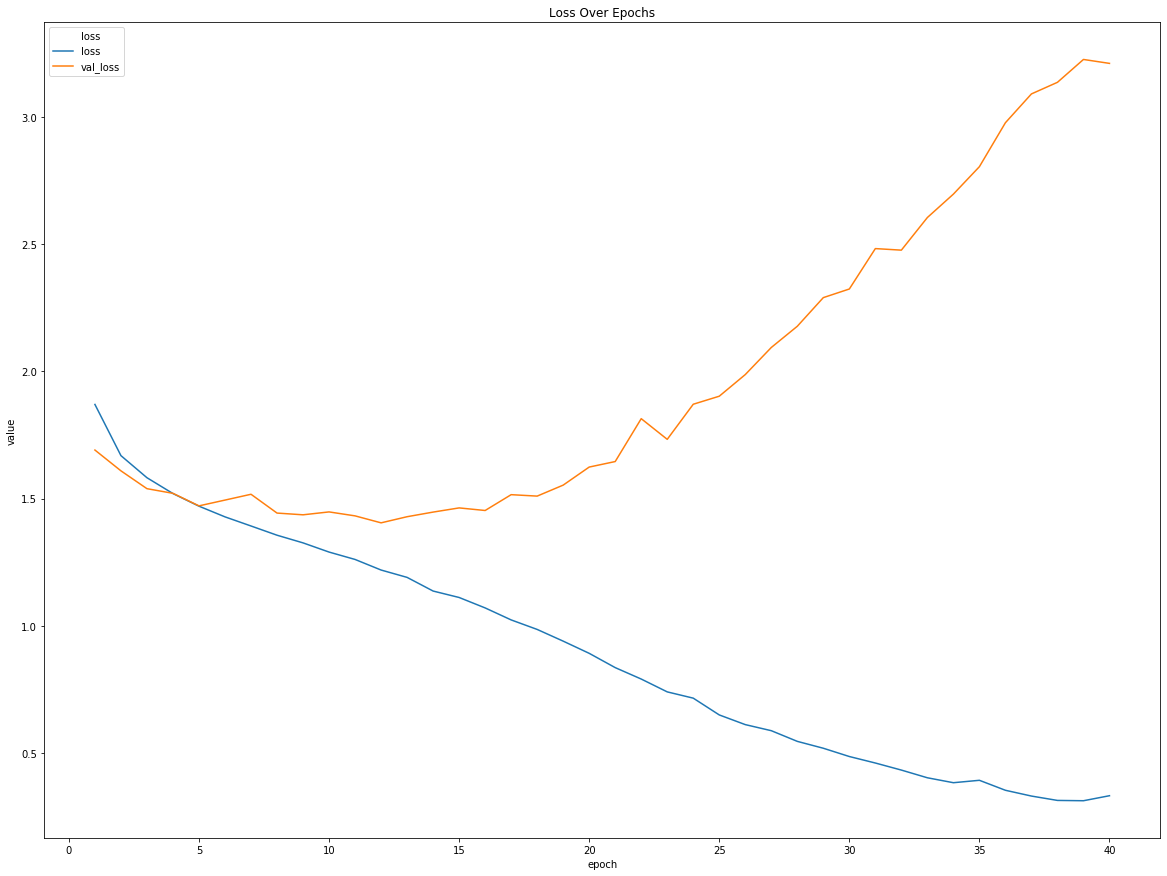

In [72]:
loss1 = loss[['epoch','loss', 'val_loss']].melt(id_vars=['epoch'], var_name='loss')
plt.figure(figsize=(20.0, 15.0))
plt.title('Loss Over Epochs')
plot = sns.lineplot(data=loss1, x='epoch', y='value', hue='loss')
fig = plot.get_figure()
fig.savefig("model07_loss.png")

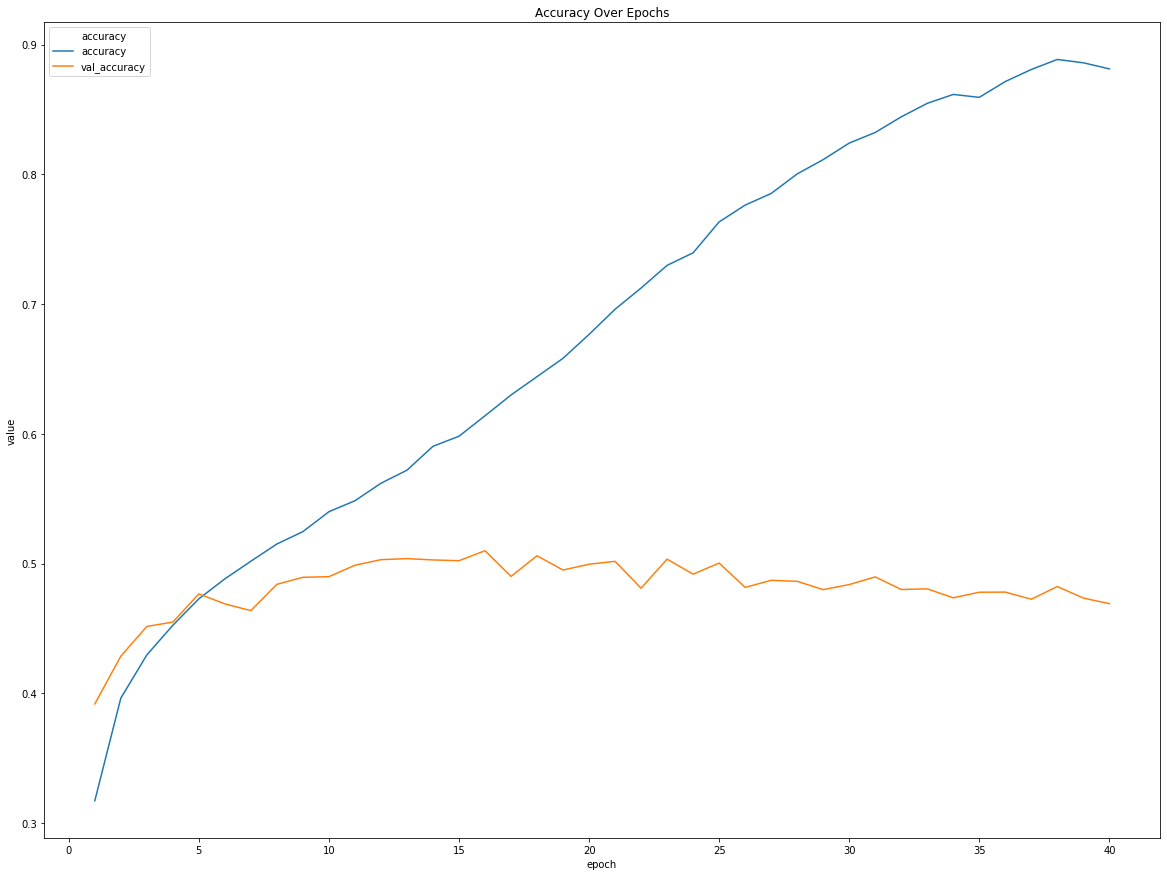

In [73]:
acc = loss[['epoch','accuracy', 'val_accuracy']].melt(id_vars=['epoch'], var_name='accuracy')
fig = plt.figure(figsize=(20.0, 15.0))
plt.title('Accuracy Over Epochs')
sns.lineplot(data=acc, x='epoch', y='value', hue='accuracy')
plt.show()
fig.savefig("model07_accuracy.png")

Well, now we have a serious overfitting issue in our hands, and also a much worse loss over epochs for the test set. We will apply some regularisation in order to limit the capacity of the network a bit, to avoid overfit.

# 8th attempt

As a first attempt at regularization, we will only apply a l2 regularization **on the weights** of each layer.

In [74]:
%%time
batch_size = 128
epochs = 40

model = Sequential()
model.add(Dense(400, activation='relu', kernel_regularizer=l2(0.001), input_shape=(3072,)))
model.add(Dense(400, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dense(400, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dense(400, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dense(num_classes, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_57 (Dense)             (None, 400)               1229200   
_________________________________________________________________
dense_58 (Dense)             (None, 400)               160400    
_________________________________________________________________
dense_59 (Dense)             (None, 400)               160400    
_________________________________________________________________
dense_60 (Dense)             (None, 400)               160400    
_________________________________________________________________
dense_61 (Dense)             (None, 10)                4010      
Total params: 1,714,410
Trainable params: 1,714,410
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/40
50000/50000 [==============================] - 1

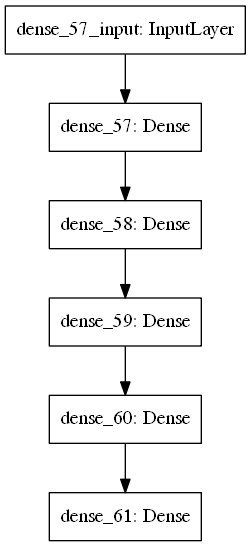

In [75]:
plot_model(model, to_file='model08.png')

In [76]:
loss = pd.DataFrame.from_dict(history.history)
loss['epoch'] = loss.index+1

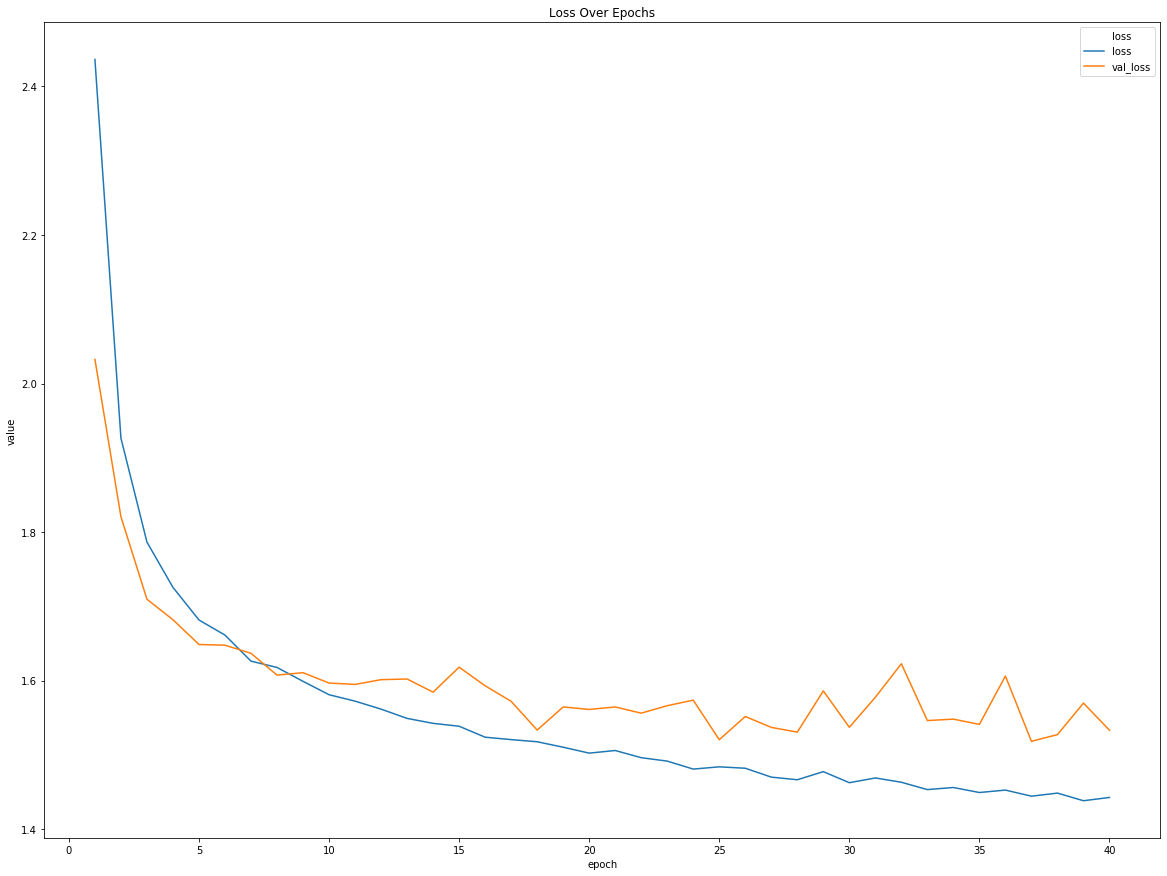

In [77]:
loss1 = loss[['epoch','loss', 'val_loss']].melt(id_vars=['epoch'], var_name='loss')
plt.figure(figsize=(20.0, 15.0))
plt.title('Loss Over Epochs')
plot = sns.lineplot(data=loss1, x='epoch', y='value', hue='loss')
fig = plot.get_figure()
fig.savefig("model08_loss.png")

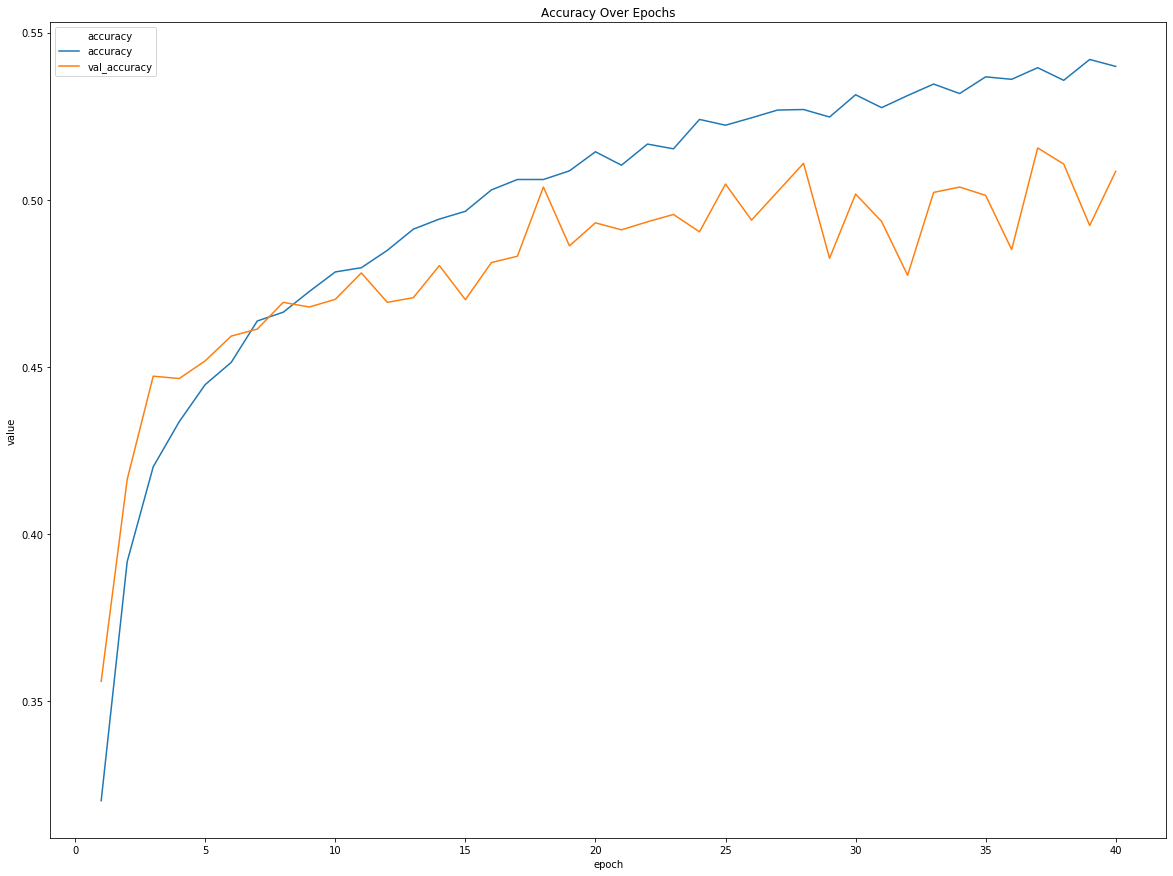

In [78]:
acc = loss[['epoch','accuracy', 'val_accuracy']].melt(id_vars=['epoch'], var_name='accuracy')
fig = plt.figure(figsize=(20.0, 15.0))
plt.title('Accuracy Over Epochs')
sns.lineplot(data=acc, x='epoch', y='value', hue='accuracy')
plt.show()
fig.savefig("model08_accuracy.png")

This seems to have vastly improved the generalization issue. But once again the capacity seems handicapped. We will try to fix that by increasing the depth of the network. 

# 9th attempt

Adding an extra dense layer and removing the regularisation from some layers. Adding a dropout layer after each unregularised layer to compensate. 

In [79]:
%%time
batch_size = 128
epochs = 40

model = Sequential()
model.add(Dense(500, activation='relu', input_shape=(3072,)))
model.add(Dense(500, activation='relu'))
model.add(Dropout(rate=0.1))
model.add(Dense(500, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dense(500, activation='relu'))
model.add(Dropout(rate=0.1))
model.add(Dense(500, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dense(num_classes, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_62 (Dense)             (None, 500)               1536500   
_________________________________________________________________
dense_63 (Dense)             (None, 500)               250500    
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_64 (Dense)             (None, 500)               250500    
_________________________________________________________________
dense_65 (Dense)             (None, 500)               250500    
_________________________________________________________________
dropout_2 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_66 (Dense)             (None, 500)             

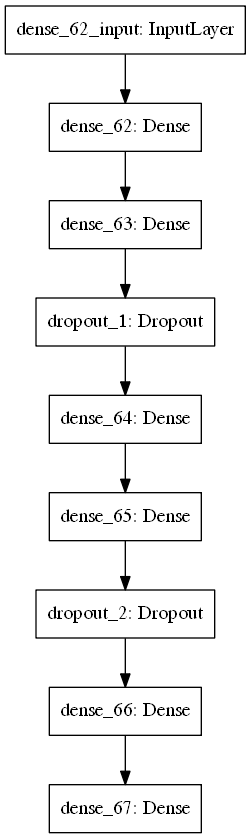

In [80]:
plot_model(model, to_file='model09.png')

In [81]:
loss = pd.DataFrame.from_dict(history.history)
loss['epoch'] = loss.index+1

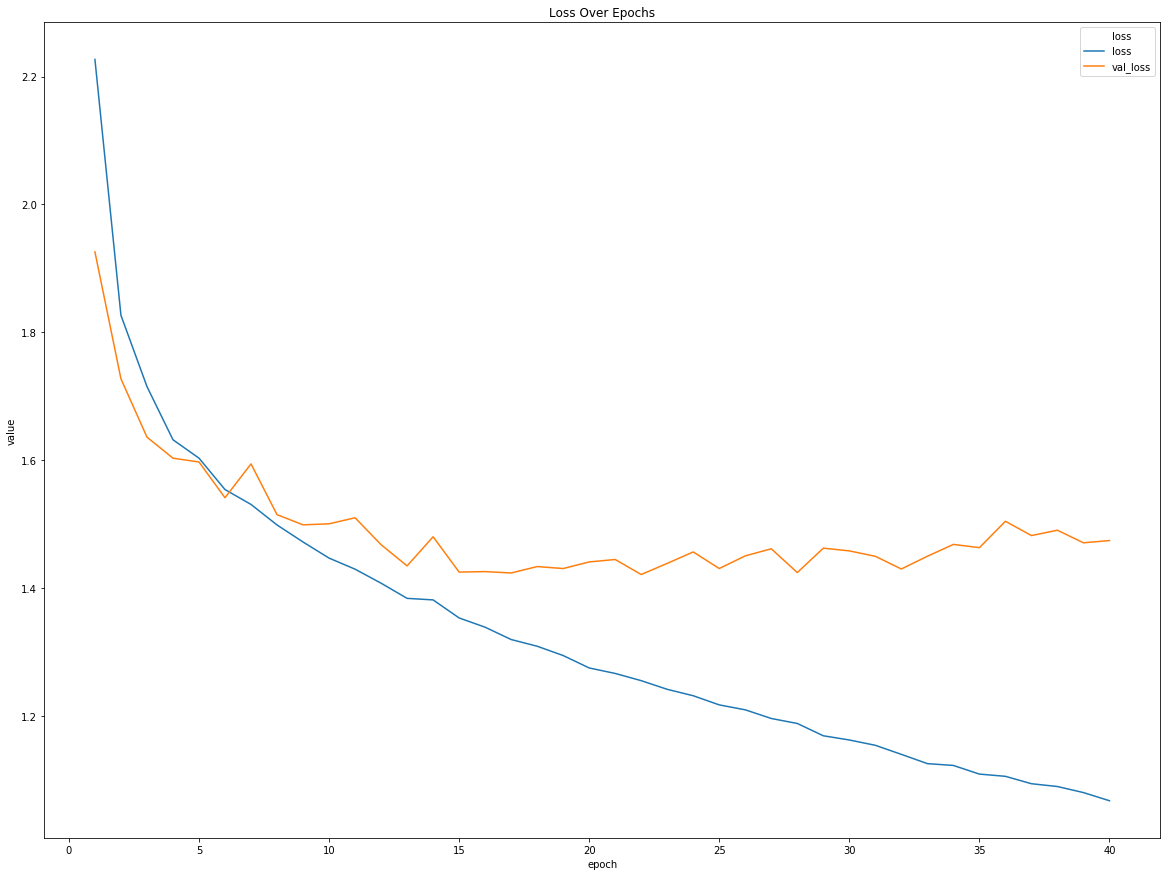

In [82]:
loss1 = loss[['epoch','loss', 'val_loss']].melt(id_vars=['epoch'], var_name='loss')
plt.figure(figsize=(20.0, 15.0))
plt.title('Loss Over Epochs')
plot = sns.lineplot(data=loss1, x='epoch', y='value', hue='loss')
fig = plot.get_figure()
fig.savefig("model09_loss.png")

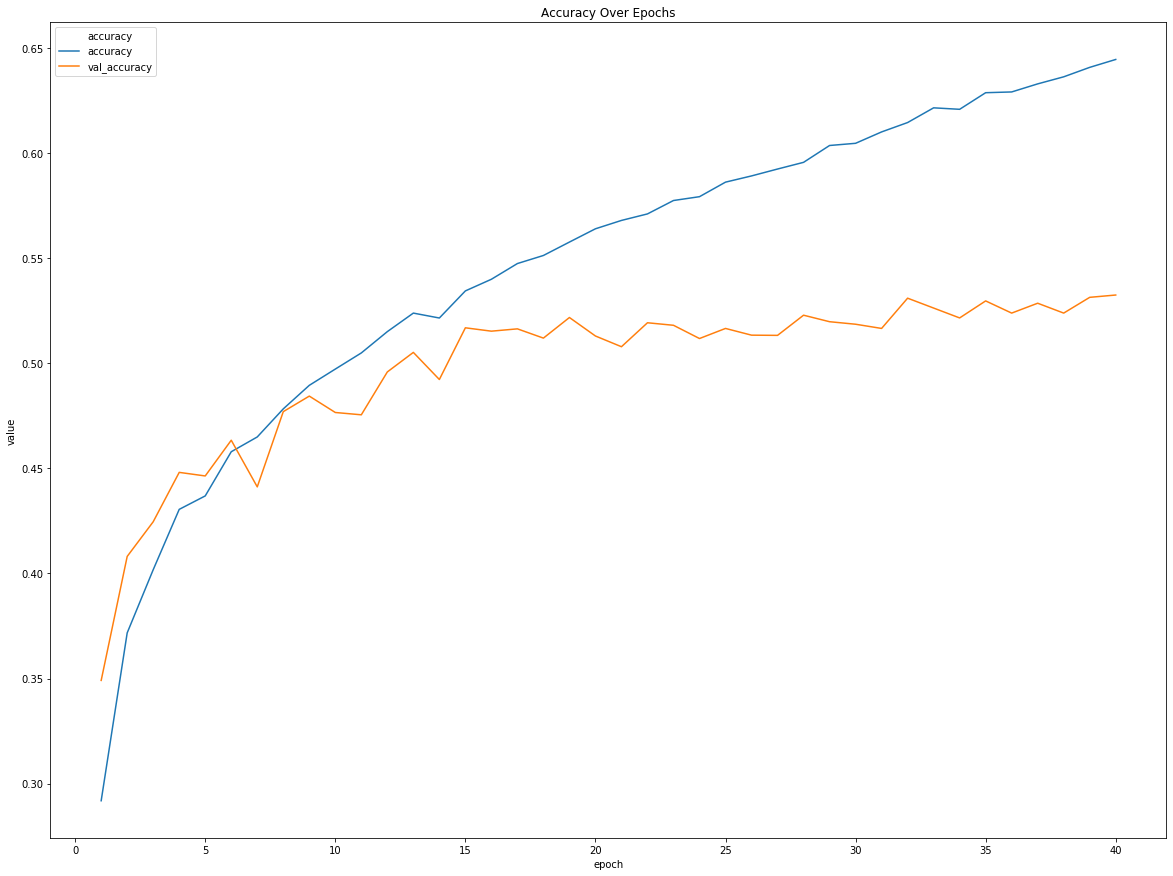

In [83]:
acc = loss[['epoch','accuracy', 'val_accuracy']].melt(id_vars=['epoch'], var_name='accuracy')
fig = plt.figure(figsize=(20.0, 15.0))
plt.title('Accuracy Over Epochs')
sns.lineplot(data=acc, x='epoch', y='value', hue='accuracy')
plt.show()
fig.savefig("model09_accuracy.png")

# 10th Attempt

Changing all regularisation layers to dropout layers. Increasing the epochs to compensate. 

In [84]:
%%time
batch_size = 128
epochs = 60

model = Sequential()
model.add(Dense(500, activation='relu', input_shape=(3072,)))
model.add(Dropout(rate=0.2))
model.add(Dense(500, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(500, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(500, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(500, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(num_classes, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_68 (Dense)             (None, 500)               1536500   
_________________________________________________________________
dropout_3 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_69 (Dense)             (None, 500)               250500    
_________________________________________________________________
dropout_4 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_70 (Dense)             (None, 500)               250500    
_________________________________________________________________
dropout_5 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_71 (Dense)             (None, 500)             

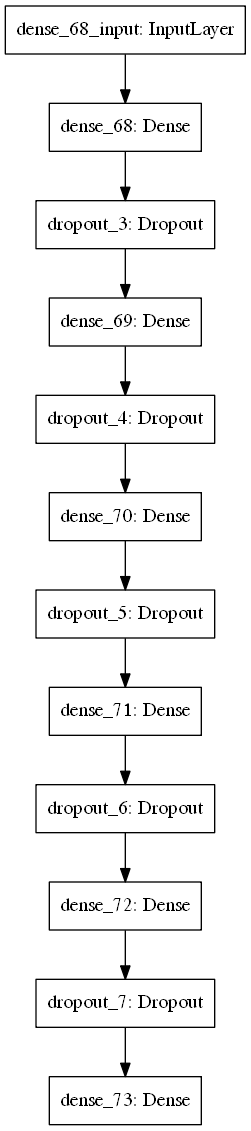

In [85]:
plot_model(model, to_file='model10.png')

In [86]:
loss = pd.DataFrame.from_dict(history.history)
loss['epoch'] = loss.index+1

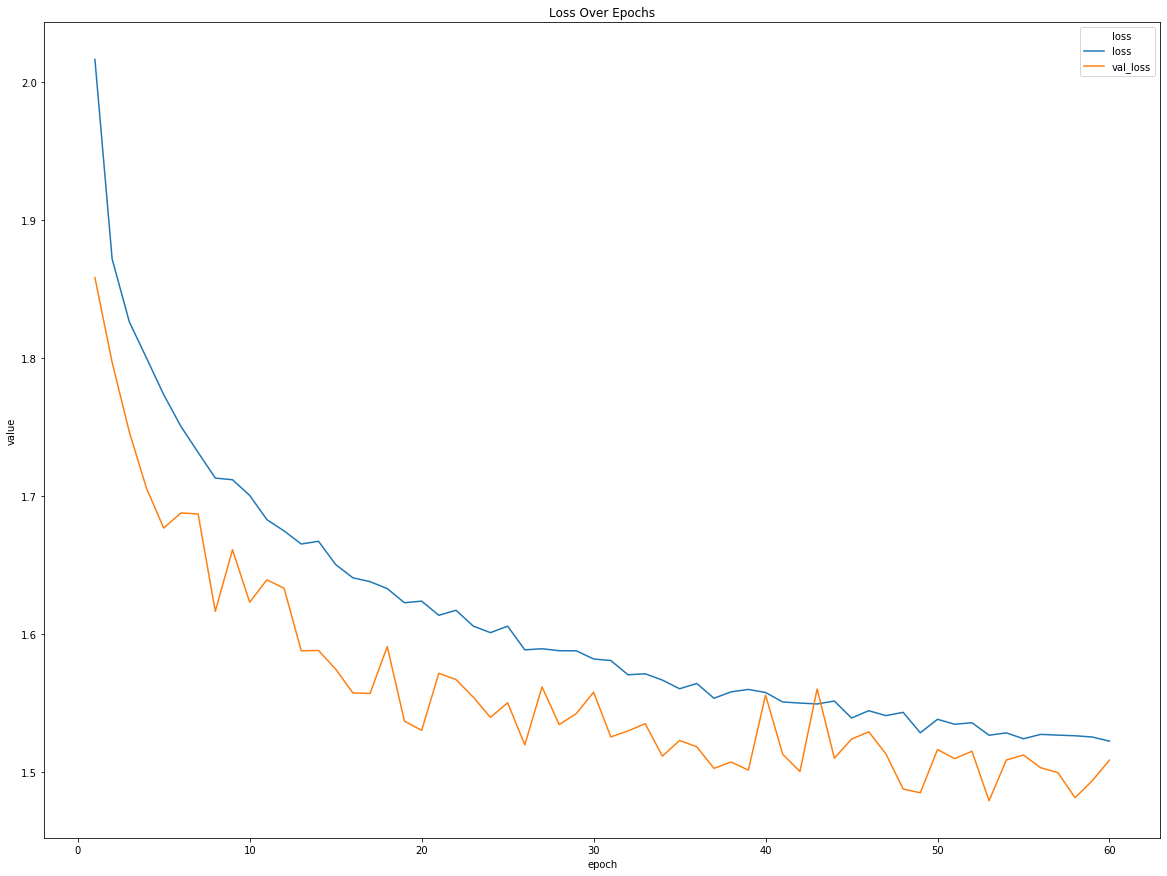

In [87]:
loss1 = loss[['epoch','loss', 'val_loss']].melt(id_vars=['epoch'], var_name='loss')
plt.figure(figsize=(20.0, 15.0))
plt.title('Loss Over Epochs')
plot = sns.lineplot(data=loss1, x='epoch', y='value', hue='loss')
fig = plot.get_figure()
fig.savefig("model10_loss.png")

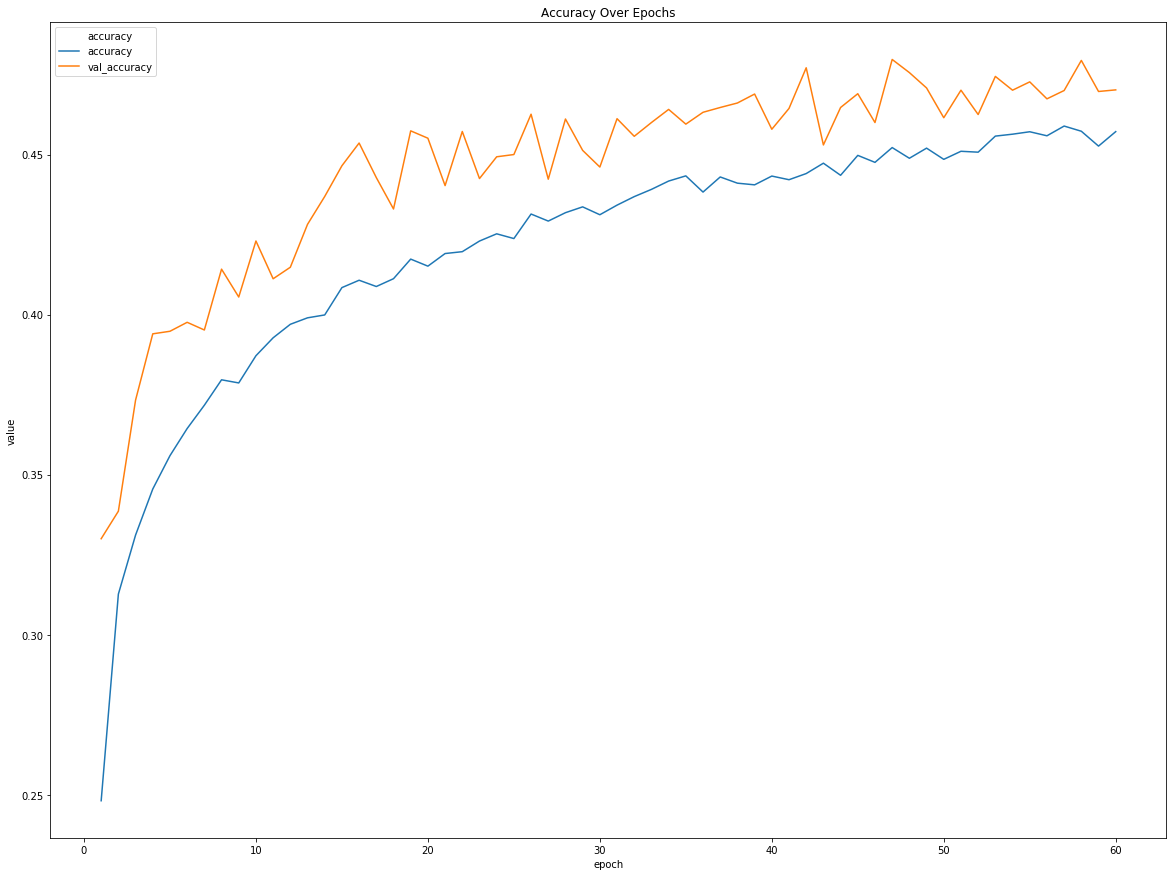

In [88]:
acc = loss[['epoch','accuracy', 'val_accuracy']].melt(id_vars=['epoch'], var_name='accuracy')
fig = plt.figure(figsize=(20.0, 15.0))
plt.title('Accuracy Over Epochs')
sns.lineplot(data=acc, x='epoch', y='value', hue='accuracy')
plt.show()
fig.savefig("model10_accuracy.png")

# 11th Attempt

So far model 9 has been the best. The epoch increase seems to have helped, but too many dropouts seem to handicap the model. We will use the same architecture as model 9, but this time with more epochs and also utilising early stopping. According to the book (chapter 7.8) in the cases where the train error decreases consistently over time, while the validation error forms som asymmetric U-shaped curve, it is often the case that early stopping helps. The idea is that we return to the parameter setting that had the lowest validation set error and iterate on those until we manage to improve upon them. If not, we output those best recorded parameters. 

In [89]:
%%time
batch_size = 128
epochs = 60
#setting the patience parameter for the Early Stopping
pat = 10

model = Sequential()
model.add(Dense(500, activation='relu', input_shape=(3072,)))
model.add(Dense(500, activation='relu'))
model.add(Dropout(rate=0.1))
model.add(Dense(500, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dense(500, activation='relu'))
model.add(Dropout(rate=0.1))
model.add(Dense(500, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dense(num_classes, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
es = EarlyStopping(monitor='val_accuracy',
                   patience=pat,
                   verbose=True,
                   mode='max',
                   restore_best_weights=True
                   )
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    callbacks=[es])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_74 (Dense)             (None, 500)               1536500   
_________________________________________________________________
dense_75 (Dense)             (None, 500)               250500    
_________________________________________________________________
dropout_8 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_76 (Dense)             (None, 500)               250500    
_________________________________________________________________
dense_77 (Dense)             (None, 500)               250500    
_________________________________________________________________
dropout_9 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_78 (Dense)             (None, 500)             

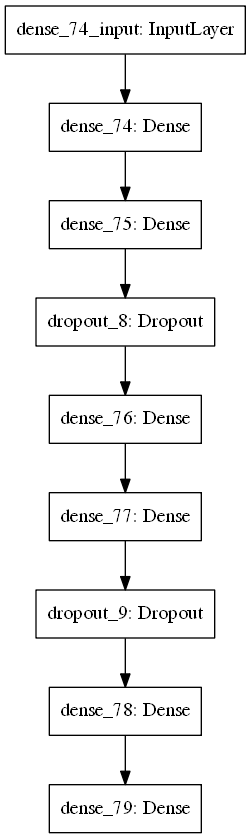

In [90]:
plot_model(model, to_file='model11.png')

In [91]:
loss = pd.DataFrame.from_dict(history.history)
loss['epoch'] = loss.index+1

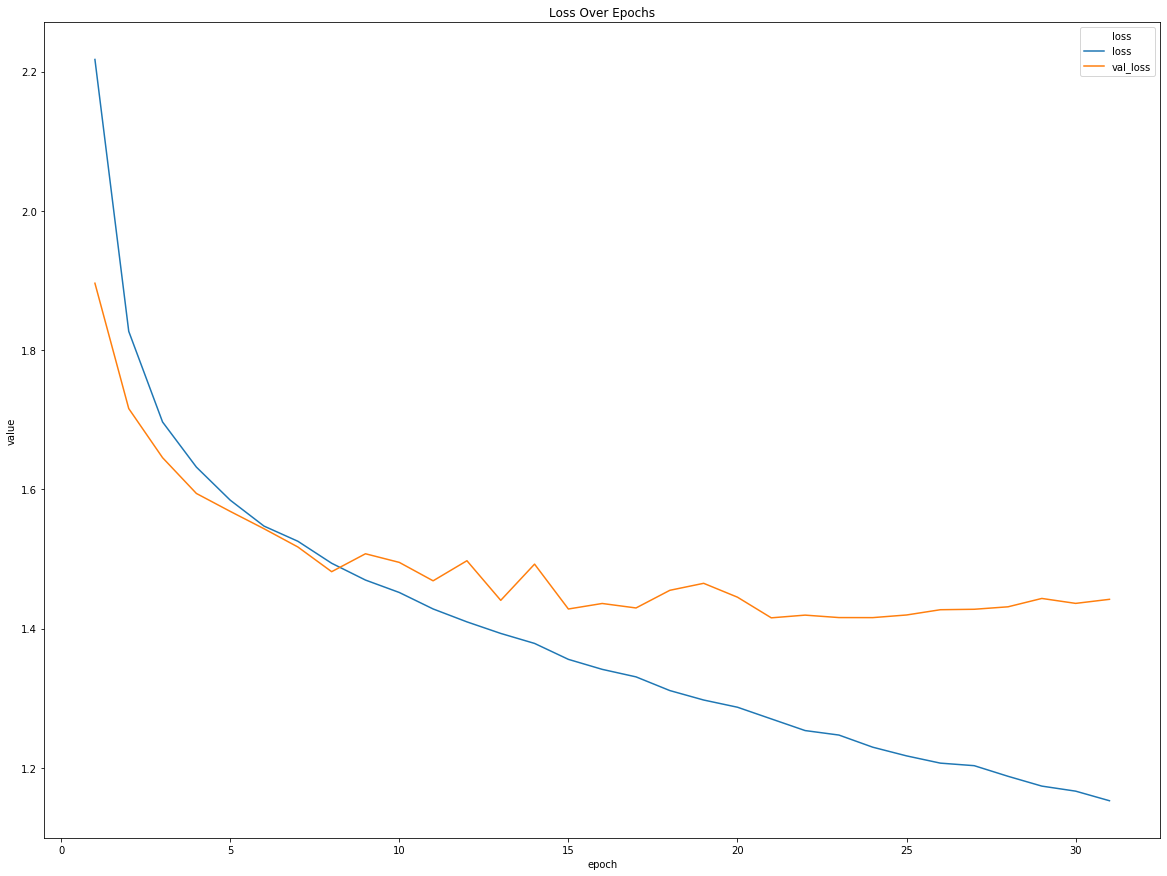

In [92]:
loss1 = loss[['epoch','loss', 'val_loss']].melt(id_vars=['epoch'], var_name='loss')
plt.figure(figsize=(20.0, 15.0))
plt.title('Loss Over Epochs')
plot = sns.lineplot(data=loss1, x='epoch', y='value', hue='loss')
fig = plot.get_figure()
fig.savefig("model11_loss.png")

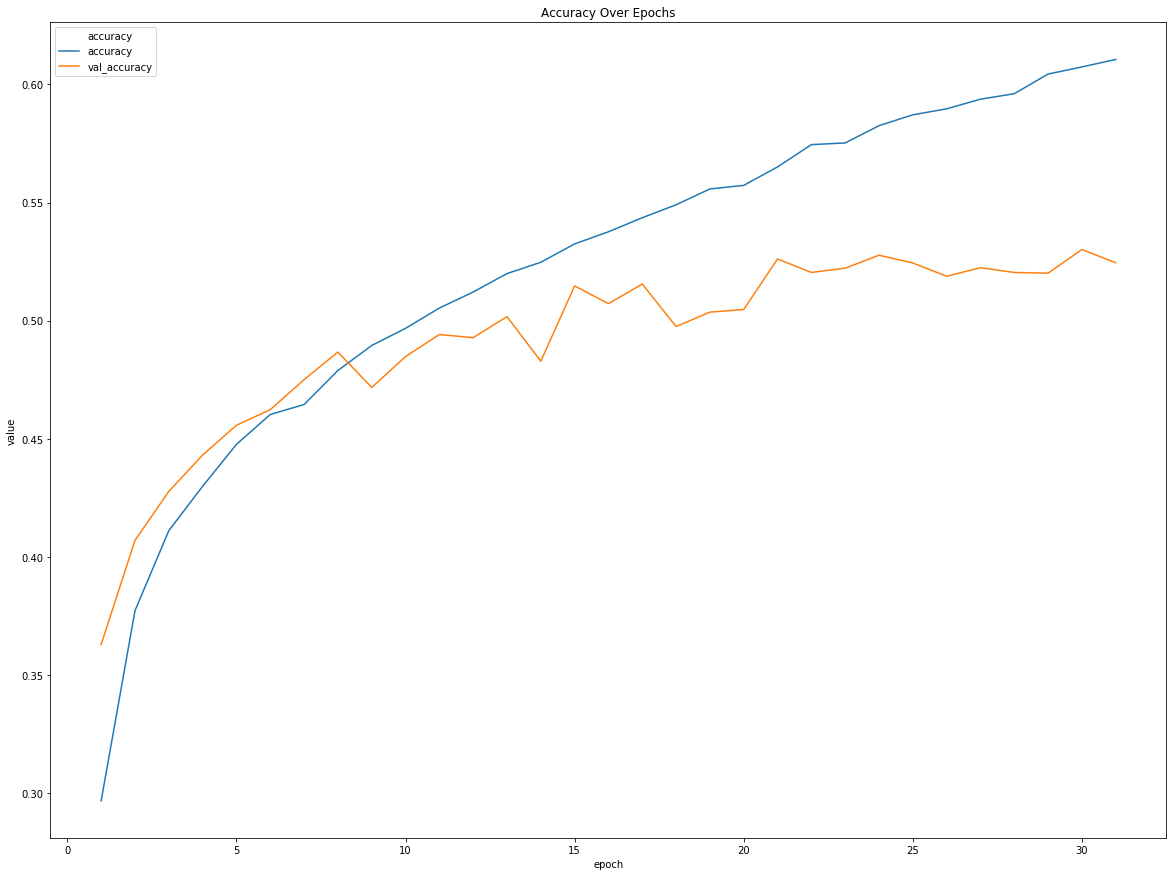

In [93]:
acc = loss[['epoch','accuracy', 'val_accuracy']].melt(id_vars=['epoch'], var_name='accuracy')
fig = plt.figure(figsize=(20.0, 15.0))
plt.title('Accuracy Over Epochs')
sns.lineplot(data=acc, x='epoch', y='value', hue='accuracy')
plt.show()
fig.savefig("model11_accuracy.png")

# 12th Attempt

Things are improving, but we still have a generalization issue. According to the book, smaller batches can offer a regularizing effect, due to the noise they add to the learning process. We decide to decrease the batch size to 64. 

In [22]:
%%time
batch_size = 256
epochs = 60
pat = 10

model = Sequential()
model.add(Dense(500, activation='relu', input_shape=(3072,)))
model.add(Dense(500, activation='relu'))
model.add(Dropout(rate=0.1))
model.add(Dense(500, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dense(500, activation='relu'))
model.add(Dropout(rate=0.1))
model.add(Dense(500, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dense(num_classes, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
es = EarlyStopping(monitor='val_accuracy',
                   patience=pat,
                   verbose=True,
                   mode='max',
                   restore_best_weights=True
                   )
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    callbacks=[es])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 500)               1536500   
_________________________________________________________________
dense_14 (Dense)             (None, 500)               250500    
_________________________________________________________________
dropout_5 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 500)               250500    
_________________________________________________________________
dense_16 (Dense)             (None, 500)               250500    
_________________________________________________________________
dropout_6 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 500)              

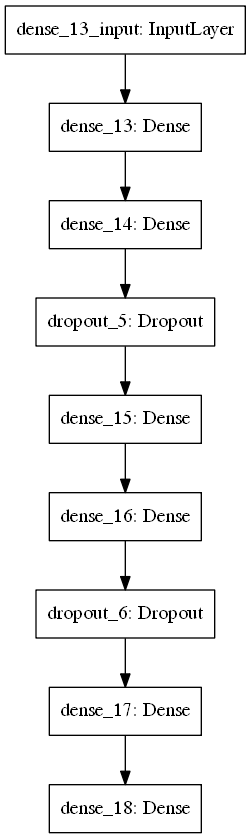

In [23]:
plot_model(model, to_file='model12.png')

In [24]:
loss = pd.DataFrame.from_dict(history.history)
loss['epoch'] = loss.index+1

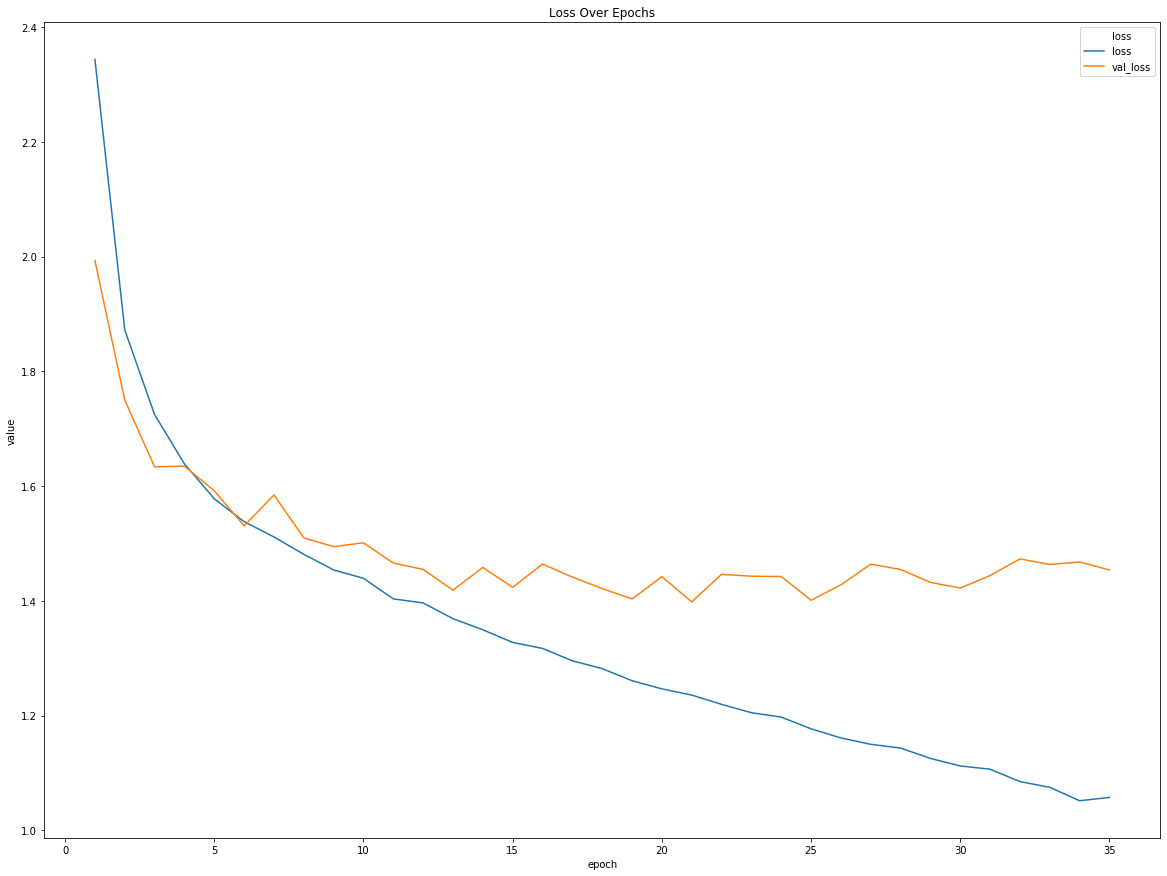

In [25]:
loss1 = loss[['epoch','loss', 'val_loss']].melt(id_vars=['epoch'], var_name='loss')
plt.figure(figsize=(20.0, 15.0))
plt.title('Loss Over Epochs')
plot = sns.lineplot(data=loss1, x='epoch', y='value', hue='loss')
fig = plot.get_figure()
fig.savefig("model12_loss.png")

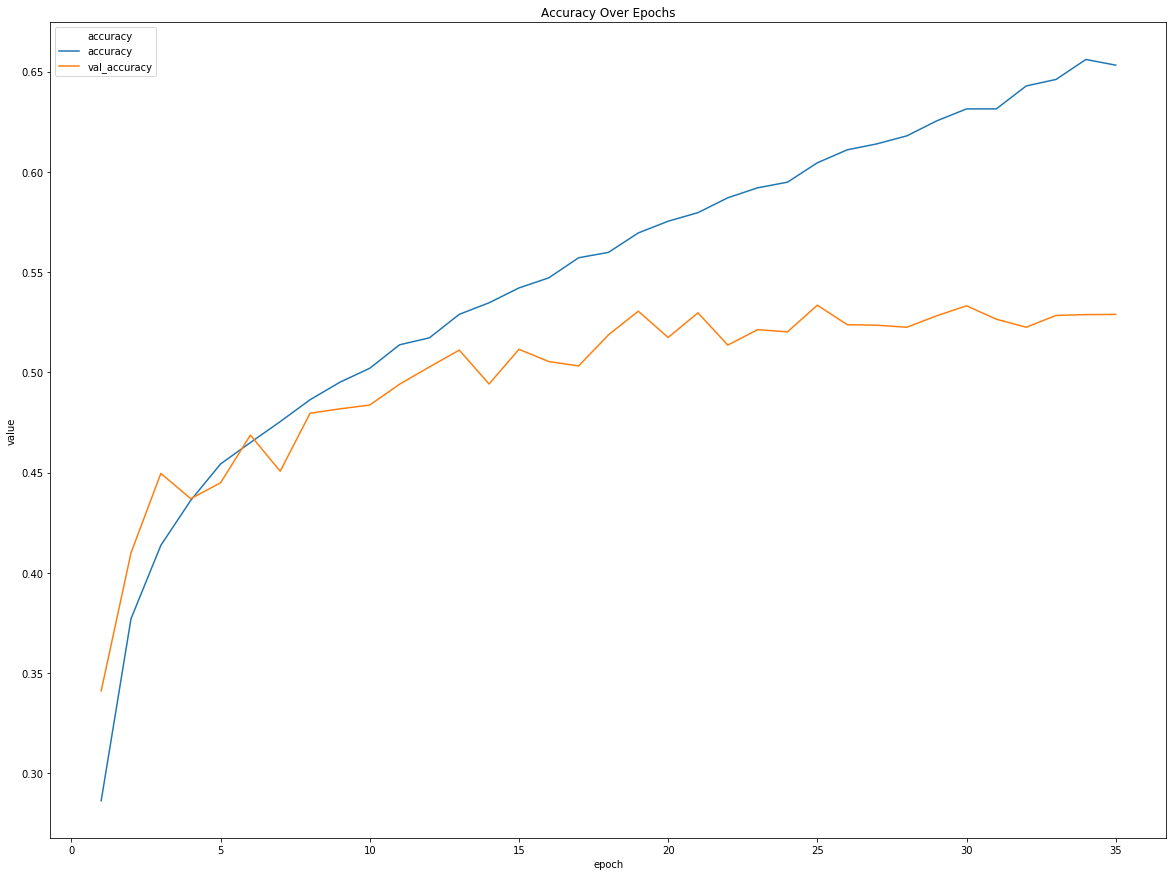

In [26]:
acc = loss[['epoch','accuracy', 'val_accuracy']].melt(id_vars=['epoch'], var_name='accuracy')
fig = plt.figure(figsize=(20.0, 15.0))
plt.title('Accuracy Over Epochs')
sns.lineplot(data=acc, x='epoch', y='value', hue='accuracy')
plt.show()
fig.savefig("model12_accuracy.png")

# 13th Attempt

We take a look at what would happen if we followed Janocha, K., & Czarnecki, W. M. (2017). On loss functions for deep neural networks in classification. arXiv preprint arXiv:1702.05659. Their reserch shows that despite theoretical advantages of categorical cross-entropy, hinge loss works better. 

In [28]:
%%time
batch_size = 256
epochs = 60
pat = 10

model = Sequential()
model.add(Dense(500, activation='relu', input_shape=(3072,)))
model.add(Dense(500, activation='relu'))
model.add(Dropout(rate=0.1))
model.add(Dense(500, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dense(500, activation='relu'))
model.add(Dropout(rate=0.1))
model.add(Dense(500, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dense(num_classes, activation='softmax'))
model.summary()
model.compile(loss='hinge',
              optimizer=Adam(),
              metrics=['accuracy'])
es = EarlyStopping(monitor='val_accuracy',
                   patience=pat,
                   verbose=True,
                   mode='max',
                   restore_best_weights=True
                   )
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    callbacks=[es])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 500)               1536500   
_________________________________________________________________
dense_26 (Dense)             (None, 500)               250500    
_________________________________________________________________
dropout_9 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 500)               250500    
_________________________________________________________________
dense_28 (Dense)             (None, 500)               250500    
_________________________________________________________________
dropout_10 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 500)              

50000/50000 [==============================] - 12s 248us/step - loss: 1.0336 - accuracy: 0.3452 - val_loss: 1.0326 - val_accuracy: 0.3487
Epoch 46/60
50000/50000 [==============================] - 13s 250us/step - loss: 1.0325 - accuracy: 0.3497 - val_loss: 1.0350 - val_accuracy: 0.3371
Epoch 47/60
50000/50000 [==============================] - 14s 275us/step - loss: 1.0325 - accuracy: 0.3497 - val_loss: 1.0300 - val_accuracy: 0.3634
Epoch 48/60
50000/50000 [==============================] - 14s 278us/step - loss: 1.0316 - accuracy: 0.3547 - val_loss: 1.0319 - val_accuracy: 0.3517
Epoch 49/60
50000/50000 [==============================] - 14s 273us/step - loss: 1.0312 - accuracy: 0.3555 - val_loss: 1.0292 - val_accuracy: 0.3655
Epoch 50/60
50000/50000 [==============================] - 14s 273us/step - loss: 1.0326 - accuracy: 0.3498 - val_loss: 1.0298 - val_accuracy: 0.3617
Epoch 51/60
50000/50000 [==============================] - 14s 278us/step - loss: 1.0320 - accuracy: 0.3523 - va

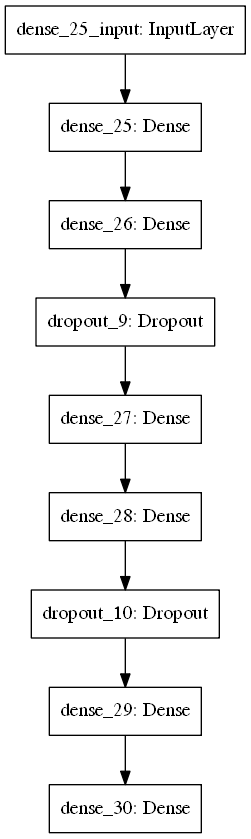

In [29]:
plot_model(model, to_file='model13.png')

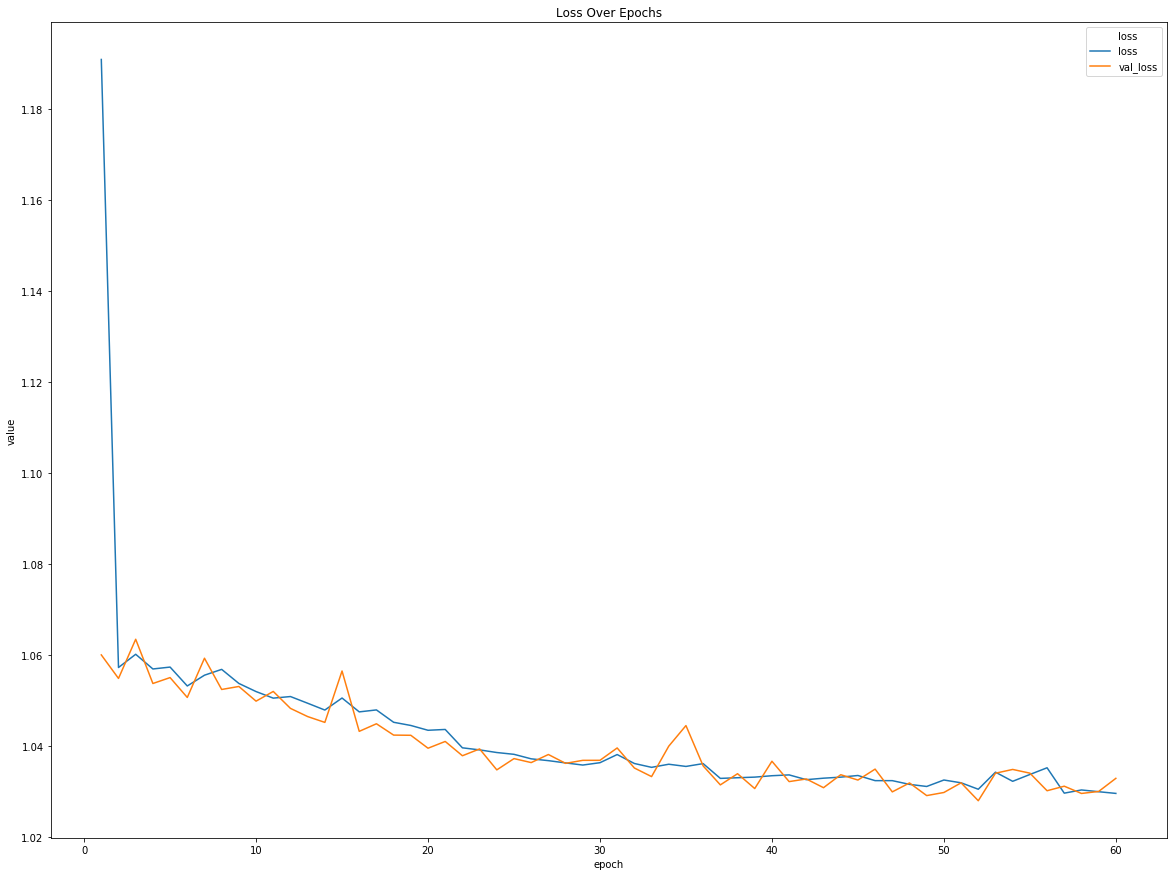

In [30]:
loss = pd.DataFrame.from_dict(history.history)
loss['epoch'] = loss.index+1
loss1 = loss[['epoch','loss', 'val_loss']].melt(id_vars=['epoch'], var_name='loss')
plt.figure(figsize=(20.0, 15.0))
plt.title('Loss Over Epochs')
plot = sns.lineplot(data=loss1, x='epoch', y='value', hue='loss')
fig = plot.get_figure()
fig.savefig("model13_loss.png")

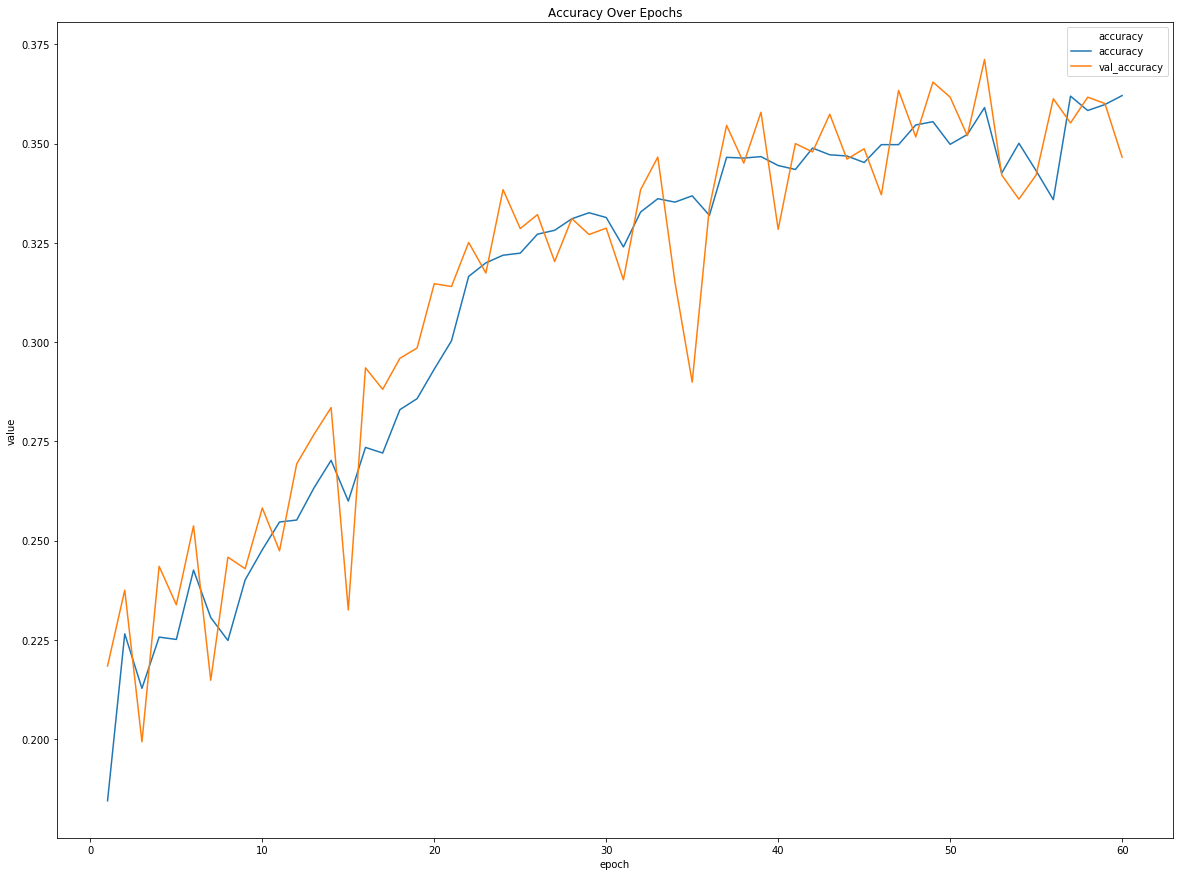

In [31]:
acc = loss[['epoch','accuracy', 'val_accuracy']].melt(id_vars=['epoch'], var_name='accuracy')
fig = plt.figure(figsize=(20.0, 15.0))
plt.title('Accuracy Over Epochs')
sns.lineplot(data=acc, x='epoch', y='value', hue='accuracy')
plt.show()
fig.savefig("model13_accuracy.png")

# 14th attempt

Attempt at batch normalization

In [47]:
%%time
batch_size = 256
epochs = 60
pat = 10

model = Sequential()
model.add(Dense(500, use_bias=False, input_shape=(3072,)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(rate=0.5))
model.add(Dense(500, activation='relu'))
model.add(Dense(500, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(rate=0.3))
model.add(Dense(500, activation='relu'))
model.add(Dense(500, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(rate=0.1))
model.add(Dense(num_classes, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
es = EarlyStopping(monitor='val_accuracy',
                   patience=pat,
                   verbose=True,
                   mode='max',
                   restore_best_weights=True
                   )
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    callbacks=[es])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_62 (Dense)             (None, 500)               1536000   
_________________________________________________________________
batch_normalization_7 (Batch (None, 500)               2000      
_________________________________________________________________
activation_6 (Activation)    (None, 500)               0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 500)               0         
_________________________________________________________________
dense_63 (Dense)             (None, 500)               250500    
_________________________________________________________________
dense_64 (Dense)             (None, 500)               250500    
_________________________________________________________________
dropout_25 (Dropout)         (None, 500)             

Test loss: 1.3993679977416993
Test accuracy: 0.5302000045776367
Wall time: 10min 20s


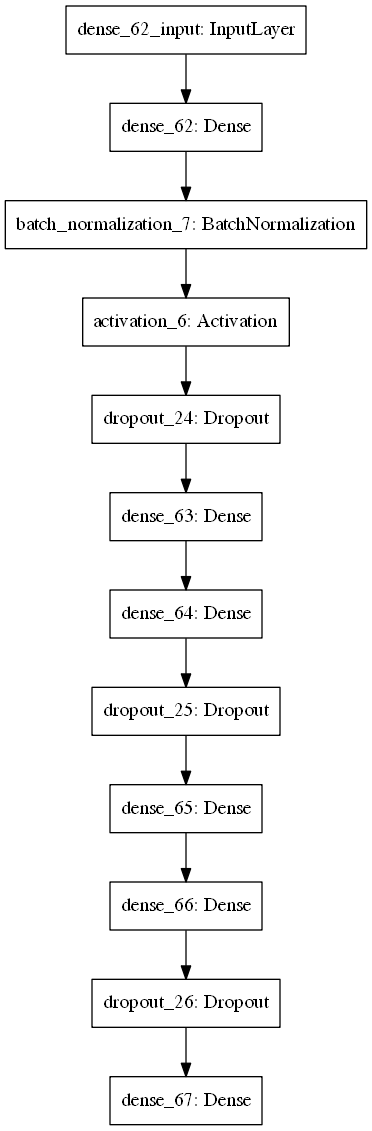

In [48]:
plot_model(model, to_file='model14.png')

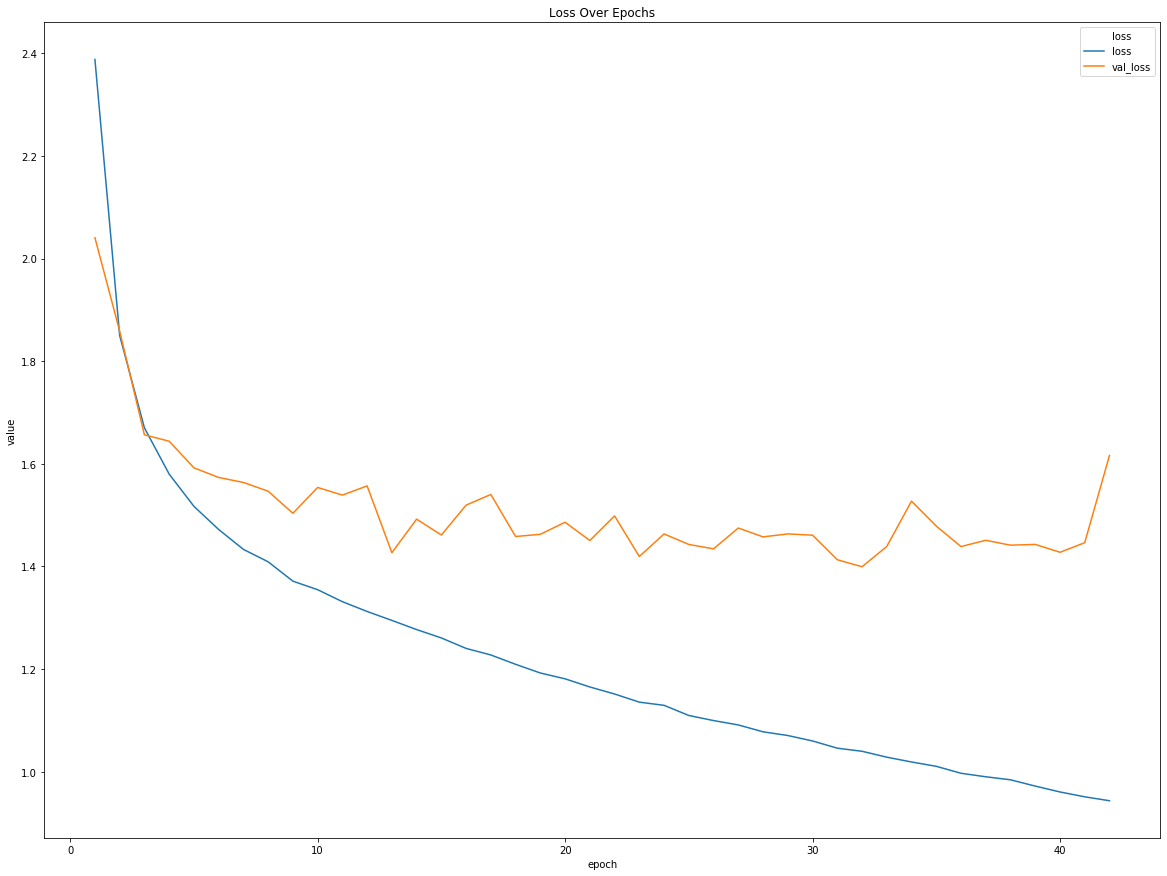

In [49]:
loss = pd.DataFrame.from_dict(history.history)
loss['epoch'] = loss.index+1
loss1 = loss[['epoch','loss', 'val_loss']].melt(id_vars=['epoch'], var_name='loss')
plt.figure(figsize=(20.0, 15.0))
plt.title('Loss Over Epochs')
plot = sns.lineplot(data=loss1, x='epoch', y='value', hue='loss')
fig = plot.get_figure()
fig.savefig("model14_loss.png")

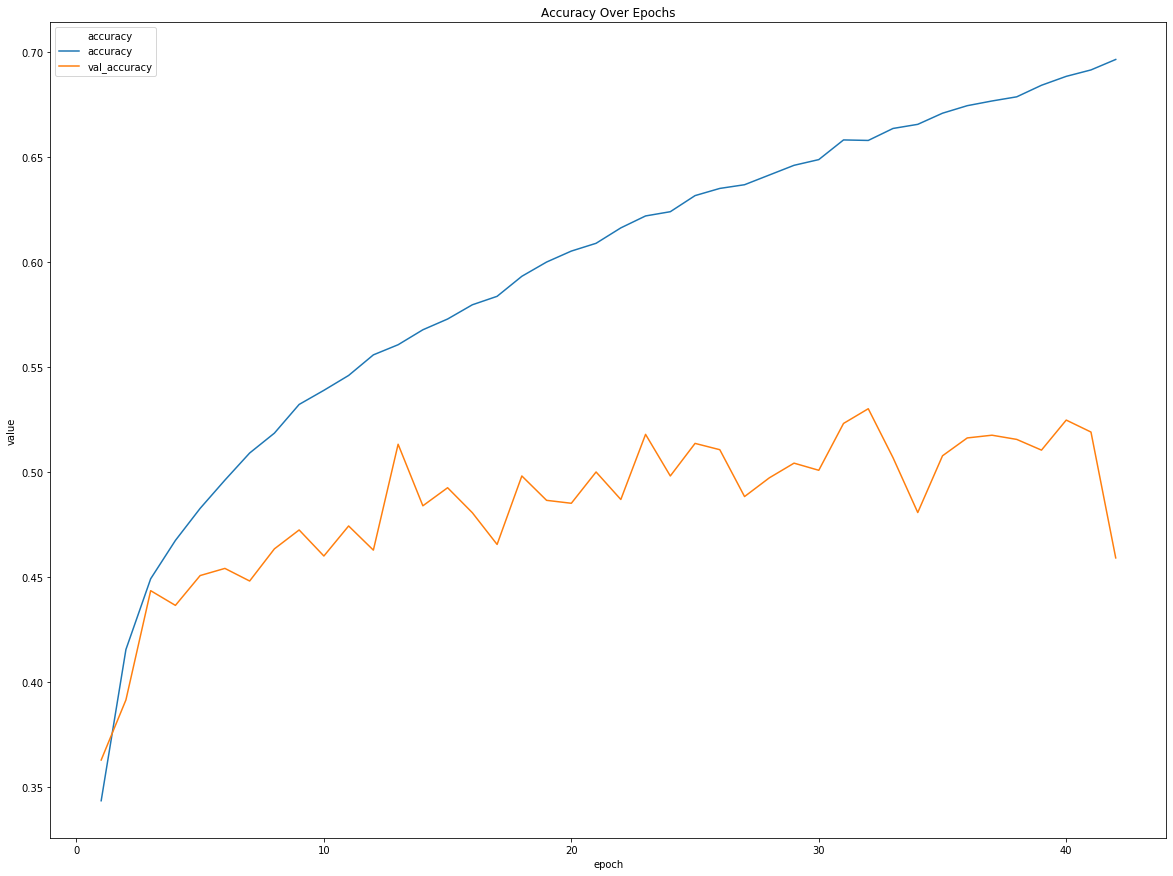

In [50]:
acc = loss[['epoch','accuracy', 'val_accuracy']].melt(id_vars=['epoch'], var_name='accuracy')
fig = plt.figure(figsize=(20.0, 15.0))
plt.title('Accuracy Over Epochs')
sns.lineplot(data=acc, x='epoch', y='value', hue='accuracy')
plt.show()
fig.savefig("model14_accuracy.png")

# 15th Attempt

Attempt at data augmentation

In [53]:
#first we have to reload the data

In [54]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [59]:
x_train /= 255
x_test /= 255

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  # Remove the CWD from sys.path while we load stuff.


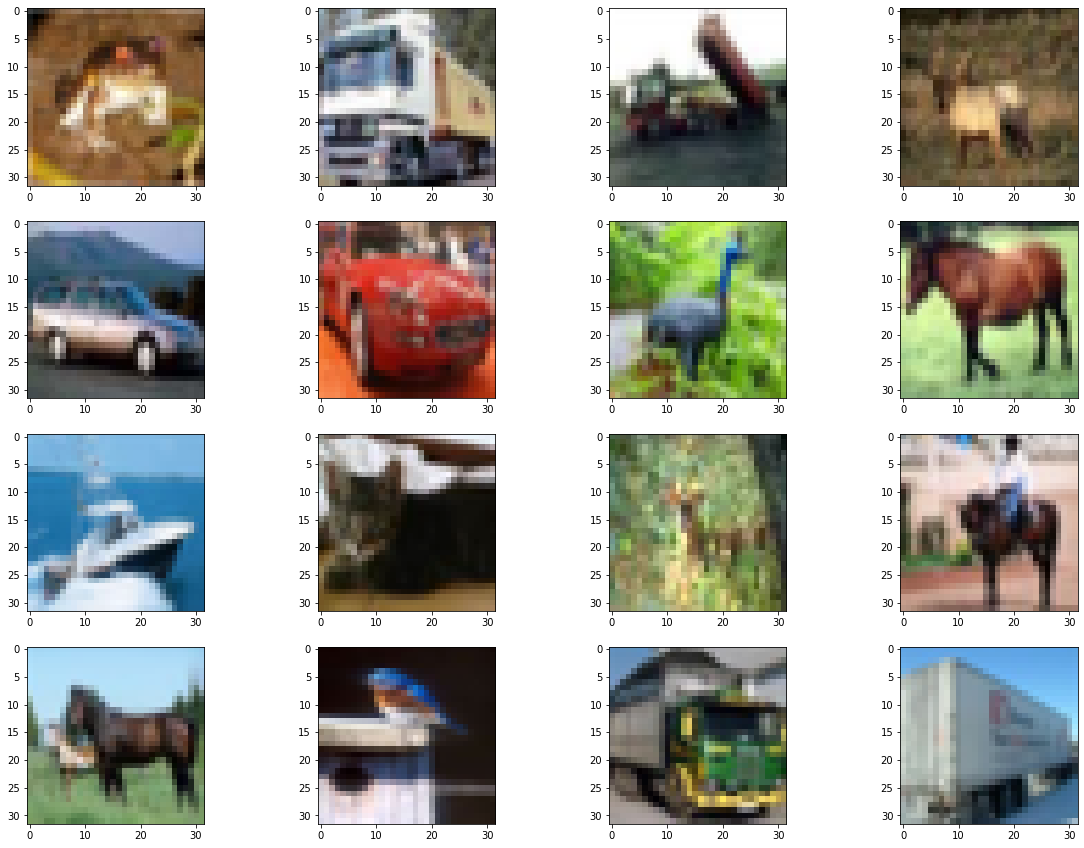

In [60]:
show_imgs(x_train[:16])

In [61]:
# adding the data augmentation part
datagen = ImageDataGenerator( rotation_range=90,
                 width_shift_range=0.1, height_shift_range=0.1,
                 horizontal_flip=True)
datagen.fit(x_train)

In [58]:
x_train.shape

(50000, 32, 32, 3)

In [71]:
%%time
batch_size = 512
epochs = 60
pat = 10



model = Sequential()
model.add(Dense(500, use_bias=False, input_shape=x_train.shape[1:]))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Flatten())
model.add(Dropout(rate=0.5))
model.add(Dense(500, activation='relu'))
model.add(Dense(500, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(rate=0.3))
model.add(Dense(500, activation='relu'))
model.add(Dense(500, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(rate=0.1))
model.add(Dense(num_classes, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
es = EarlyStopping(monitor='val_accuracy',
                   patience=pat,
                   verbose=True,
                   mode='max',
                   restore_best_weights=True
                   )
history = model.fit_generator(datagen.flow(x_train, 
                                           y_train, 
                                           batch_size=batch_size),
                              epochs=epochs,
                              verbose=1,
                              validation_data=(x_test,y_test),
                              callbacks=[es])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_94 (Dense)             (None, 32, 32, 500)       1500      
_________________________________________________________________
batch_normalization_13 (Batc (None, 32, 32, 500)       2000      
_________________________________________________________________
activation_12 (Activation)   (None, 32, 32, 500)       0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 512000)            0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 512000)            0         
_________________________________________________________________
dense_95 (Dense)             (None, 500)               256000500 
_________________________________________________________________
dense_96 (Dense)             (None, 500)             

KeyboardInterrupt: 